In [1]:
def makePlots(m,Tmax,phimax):
    import matplotlib.pyplot as plt
    plt.figure()
    m.plotPhasesPhi()
    plt.axis([0,Tmax,0,phimax])
    plt.xlabel(R"$T$/GeV")
    plt.ylabel(R"$\sqrt{(h_1^2+h_2^2+s1^2+s2^2)}$/GeV")
    plt.title("Phase structure")
    plt.show()
def h1h2Tplot(Tmax,phimax,ratio,m):
    import matplotlib.pyplot as plt
    phases=m.phases
    plt.figure()
    for key, p in phases.items():
        h1 = p.X[...,0]
        h2 = p.X[...,1]
        plt.plot(p.T, h1, label="$H_u$")
        plt.plot(p.T, h2,linestyle='dashed', label="$H_d$")
    plt.xlabel(R"$T$/GeV")
    plt.ylabel(R"$H_u,H_d/GeV$")
    plt.title("Trace of Hu and Hd")
    #plt.axis([0.,Tmax,0.,phimax])
    #
    plt.xlim([0, Tmax])
    plt.ylim([0, phimax])
    ax = plt.gca()
    ax.set_aspect(ratio)
    ax.legend() 
    plt.show()
def HvevTplot(Tmax,phimax,ratio,m):
    import matplotlib.pyplot as plt
    phases=m.phases
    plt.figure()
    for key, p in phases.items():
        h1 = p.X[...,0]
        h2 = p.X[...,1]
        H = (h1**2+h2**2)**.5
        plt.plot(p.T, H, label="$(H_u^2+H_d^2)^{1/2}$")
        plt.plot(p.T, h1, label="$H_u$",linestyle='dashed')
        plt.plot(p.T, h2,linestyle='dashed', label="$H_d$")
    plt.xlabel(R"$T$/GeV")
    plt.ylabel(R"$VEV/GeV$")
    plt.title("Trace of $(H_u^2+H_d^2)^{1/2}$/GeV")
    #plt.axis([0.,Tmax,0.,phimax])
    #
    plt.xlim([0, Tmax])
    plt.ylim([0, phimax])
    ax = plt.gca()
    ax.set_aspect(ratio)
    ax.legend() 
    plt.show()
def h1h2STplot(Tmax,phimax,m,ratio='auto',Tmin=0,phimin=0):
    import matplotlib.pyplot as plt
    phases=m.phases
    plt.figure()
    for key, p in phases.items():
        h1 = p.X[...,0]
        h2 = p.X[...,1]
        s1  = p.X[...,2]
        s2= p.X[...,3]
        plt.plot(p.T, h1, linestyle='solid',label="$H_u$")
        plt.plot(p.T, h2, label="$H_d$")
        plt.plot(p.T, s1, linestyle='dashed', label="$s1$")
        plt.plot(p.T, s2, linestyle='dashed', label="$s2$")
    plt.xlabel(R"$T$/GeV")
    plt.ylabel(R"$H_u,H_d,s1,s2/GeV$")
    plt.title("Trace of Hu and Hd and s1,s2")
    plt.xlim([Tmin, Tmax])
    plt.ylim([phimin, phimax])
    ax = plt.gca()
    ax.set_aspect(ratio)
    ax.legend(bbox_to_anchor =(0.65, 1.25))
    plt.show()

In [7]:
import numpy as np
import sympy as sym
import time as time
import scipy

from QYcosmoTransitions import helper_functions
from QYcosmoTransitions import generic_potential


class SUSYSNRmodel(generic_potential.generic_potential):
    """
    NEW model which makes use of the *generic_potential* class.

    define the coupling constants following
    """
    def init(self,g1=0.65,g2=0.35,yt=0.995698,SMmh1=125.,v=246.,mH=2000.,mHA=2000.,mHP=2000.,tanbeta=2,
             nchi=1,nphi=1,Lambda=2000.,mchi=200.,mphi=200.,c1=1.,c2=1.,c3=0.,c4=1.,mu=50.,
             dmunum=0., dmdnum=0.,  dmudnum=0., dbeta1num=0., dbeta2num=0., dbeta3num=0., dbeta4num=0., dbeta5num=0.,
             daisy=True, daisyOption=3,CW=True,ct=True,suppression=True,Higgsino=False,renormScale=1000.,Tmax=1000.):
        """
        The name of parameters are different from our paper about SNR and DM as following:
           m1 <====> mu
           lambda1 <====>lambdaH
           lambda2 <=====> eta
           lambda12 <====> 2 * kappa
           m2^2 <=====> m02

        """
        # The init method is called by the generic_potential class, after it
        # already does some of its own initialization in the default __init__()
        # method. This is necessary for all subclasses to implement.

        # This first line is absolutely essential in all subclasses.
        # It specifies the number of field-dimensions in the theory.
        self.Ndim = 2
        self.renormScaleSq = renormScale**2
        self.Tmax=Tmax
        self.deriv_order = 4


        # self.renormScaleSq is the renormalization scale used in the
        # Coleman-Weinberg potential.
        self.g1=g1
        self.g2=g2
        self.yt=yt
        self.mh=SMmh1
        self.v=v
        self.v2=v**2
        self.mH=mH
        self.mHA=mH
        self.mHP=mH
        self.beta=np.arctan(tanbeta)
        self.tanbeta=tanbeta
        self.Lambda=Lambda
        self.mchi=mchi
        self.mphi=mphi
        self.mphi2=mphi**2
        self.c1=c1
        self.c2=c2
        self.c3=c3
        self.c4=c4
        self.mu=mu
        
        
        self.alpha=np.arctan(tanbeta)+np.pi/2
        self.mhu2=(np.sin(2*self.alpha)*np.tan(self.beta)**-1*(self.mh**2-self.mH**2)-2*np.cos(self.alpha)**2*self.mh**2-2*np.sin(self.alpha)**2*self.mH**2+4*np.cos(self.beta)**2*self.mHA**2)/4.
        self.mhd2=-np.sin(self.alpha)*np.cos(self.beta)**-1*self.mh**2*np.sin(self.alpha-self.beta)/2.-np.cos(self.alpha)*self.mH**2*(np.sin(self.alpha)*np.tan(self.beta)+np.cos(self.alpha))/2.+np.sin(self.beta)**2*self.mHA**2
        self.mhud2=self.mHA**2*np.sin(2*self.beta)/2.
        self.beta1=(np.sin(self.alpha)**2*np.cos(self.beta)**-2*self.mh**2+np.cos(self.alpha)**2*np.cos(self.beta)**-2*self.mH**2-np.tan(self.beta)**2*self.mHA**2)/self.v2
        self.beta2=(np.sin(self.beta)**-2*(np.cos(self.alpha)**2*self.mh**2+np.sin(self.alpha)**2*self.mH**2)-np.tan(self.beta)**-2*self.mHA**2)/self.v2
        self.beta3=(2*self.mHP**2+np.sin(self.alpha)*np.cos(self.alpha)*np.sin(self.beta)**-1*np.cos(self.beta)**-1*(self.mH**2-self.mh**2)-self.mHA**2)/self.v2
        self.beta4=(2*(self.mHA**2-self.mHP**2))/self.v2
        self.beta5=0.
        
        print(self.mhu2,self.mhd2,self.mhud2,self.beta1,self.beta2,self.beta3,self.beta4)
        
        self.nwt = 4
        self.nzt = 2  
        self.nwl = 2
        self.nzl = 1

        self.nt = 12
        self.nh = 1
        self.nH = 1
        self.nG0 = 1
        self.nGP = 2
        self.nHA = 1
        self.nHP = 2
        self.nchi = nchi
        self.nphi = nphi
        
        self.dmunum=dmunum
        self.dmdnum=dmdnum
        self.dmudnum=dmudnum
        self.dbeta1num=dbeta1num
        self.dbeta2num=dbeta2num
        self.dbeta3num=dbeta3num
        self.dbeta4num=dbeta4num
        self.dbeta5num=dbeta5num
        
        self.daisy=daisy
        self.daisyOption=daisyOption
        self.CW=CW
        self.ct=ct
        self.suppression=suppression
        self.Higgsino=Higgsino
        
     #   self.findCounterTerms()
    
            
    def forbidPhaseCrit(self, X):
        """
        forbidPhaseCrit is useful to set if there is, for example, a Z2 symmetry
        in the theory and you don't want to double-count all of the phases. In
        this case, we're throwing away all phases whose zeroth (since python
        starts arrays at 0) field component of the vev goes below -5. Note that
        we don't want to set this to just going below zero, since we are
        interested in phases with vevs exactly at 0, and floating point numbers
        will never be accurate enough to ensure that these aren't slightly
        negative.
        """
        return (np.array([X])[...,0] < -1.0 or np.array([X])[...,1] < -1.0).any()#or np.array([X])[...,1] < -1.0
       

    def Vcw4counter(self,X):
    
        T = 0.
        T = np.asanyarray(T, dtype=float)
        X = np.asanyarray(X, dtype=float)
        bosons = self.boson_massSq(X,T)
        fermions = self.fermion_massSq(X)
        #y = self.V0(X)
        y = self.V1(bosons, fermions)
        return y
    
    def findCounterTerms(self):     
        
        Xphys=np.array([self.v*np.sin(self.beta), self.v*np.cos(self.beta), 0., 0.])
        # create the gradient function
        fd = helper_functions.gradientFunction(self.Vcw4counter, self.x_eps, self.Ndim, self.deriv_order)
        # Need to add extra axes to T since extra axes get added to X in
        # the helper function.
      #  T = 0.
      #  T = np.asanyarray(T)[...,np.newaxis,np.newaxis]
        # get the first derivatives at the physical minimum
        Dfhu, Dfhd = fd(Xphys)
        print(fd(Xphys))
        # create the hessian function
        dh = helper_functions.hessianFunction(self.Vcw4counter, self.x_eps, self.Ndim, self.deriv_order)
        # get the hessian
        hess = dh(Xphys)
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~",hess)
        DV11 = hess[0,0]
        DV12 = hess[0,1]
        DV22 = hess[1,1]
        # solve for the coefficients of the counterterms
        self.dmunum= -(-self.v*DV11-3*self.v*DV12/np.tan(self.beta)+3*Dfhu/np.sin(self.beta))/(2*self.v)
        self.dmdnum= -(-self.v*DV22-3*self.v*DV12*np.tan(self.beta)+3*Dfhd/np.cos(self.beta))/(2*self.v)
        self.dmudnum= DV12
        self.dlambdaUnum= -(self.v*DV11/(np.sin(self.beta)**2)+self.v*DV12/(np.tan(self.beta)*np.sin(self.beta)**2)-Dfhu/(np.sin(self.beta)**3))/(self.v**3)
        self.dlambdaDnum= -(self.v*DV22/(np.cos(self.beta)**2)+self.v*DV12*np.tan(self.beta)/np.cos(self.beta)**2-Dfhd/(np.cos(self.beta)**3))/(self.v**3)
        
        print(self.dmunum,self.dmdnum,self.dmudnum,self.dlambdaUnum,self.dlambdaDnum)
      #  Pih1t= sym.re((3*self.yt**2/(8*sym.pi**2)*(-2*mt2*(self.Zfun((mt2/self.SMmh1**2).subs([(h1,self.v),(h2,0)]))-2)+.5*self.SMmh1**2*(sym.log(mt2/self.renormScaleSq)+self.Zfun((mt2/self.SMmh1**2).subs([(h1,self.v),(h2,0)]))-2))).subs([(h1,self.v),(h2,0)]).evalf())
      #  Pih1G= sym.re((3/(128*sym.pi**2)*(self.g1**2*self.SMmh1**4/mw2)*(sym.pi*3**.5-8+self.Zfun((mx12/self.SMmh1**2).subs([(h1,self.v),(h2,0)]))-sym.I*sym.pi)).subs([(h1,self.v),(h2,0)]).evalf())
      #  Pih1= Pih1t+Pih1G        
        
      #  q2= -(1.**2*.5**2)
       # Gammah1h22 = sym.re((3*self.lambda12*self.SMmh1**2/(self.v*32*sym.pi**2)*(self.Zfun((mx12/q2).subs([(h1,self.v),(h2,0)]))-2)).subs([(h1,self.v),(h2,0)]).evalf())
        
        
    
    def V0(self, X):
        """
        This method defines the tree-level potential. It should generally be
        subclassed. (You could also subclass Vtot() directly, and put in all of
        quantum corrections yourself).
        """
        # X is the input field array. It is helpful to ensure that it is a
        # numpy array before splitting it into its components.
        X = np.asanyarray(X)
        hu = X[...,0]
        hd = X[...,1]
        zeroarray=np.ones(hu.shape,dtype=float)
        s1 =  zeroarray*0.
        s2 = zeroarray*0.
        
        poTree =(self.beta1*hd**4+2*hd**2*(hu**2*(self.beta3+self.beta4)+2*self.mhd2)-8*hd*hu*self.mhud2+self.beta2*hu**4+4*hu**2*self.mhu2)/8
        
        return poTree 
        
        
    def Vct(self, X):
        """
        This method defines the tree-level potential. It should generally be
        subclassed. (You could also subclass Vtot() directly, and put in all of
        quantum corrections yourself).
        """
        # X is the input field array. It is helpful to ensure that it is a
        # numpy array before splitting it into its components.
        X = np.asanyarray(X)
        hu = X[...,0]
        hd = X[...,1]
        zeroarray=np.ones(hu.shape,dtype=float)
        s1 =  zeroarray*0.
        s2 = zeroarray*0.
        
#Oleksii# pct=(4*self.dmunum*hu**2+4*self.dmdnum*hd**2+2*hu**2*hd**2*self.dbeta35num+self.dlambdaUnum*hu**4+self.dlambdaDnum*hd**4-8*self.dmudnum*hu*hd)/8.
        pct = (4*self.dmunum*hu**2+4*self.dmdnum*hd**2+self.dbeta2num*hu**4+self.dbeta1num*hd**4-8*self.dmudnum*hu*hd+2*hu**2*hd**2*(self.dbeta3num+self.dbeta4num+self.dbeta5num))/8.

        return pct 

    
    def boson_massSq_supp(self, X, T):
        
        hu = X[...,0]
        hd = X[...,1]
        zeroarray=np.ones(hu.shape,dtype=float)
        s1 =  zeroarray*0.
        s2 = zeroarray*0.

        ringhv11=np.zeros(hu.shape)
        ringhv12=np.zeros(hu.shape)
        ringhv22=np.zeros(hu.shape)
        ringud11=np.zeros(hu.shape)
        ringud12=np.zeros(hu.shape)
        ringud22=np.zeros(hu.shape)
        ringud34=np.zeros(hu.shape)
        ringud33=np.zeros(hu.shape)
        ringud44=np.zeros(hu.shape)
        ringud55=np.zeros(hu.shape)
        ringud56=np.zeros(hu.shape)
        ringud66=np.zeros(hu.shape)

        ringchi11=np.zeros(hu.shape)
        ringchi12=np.zeros(hu.shape)
        ringchi22=np.zeros(hu.shape)

        ringphi11=np.zeros(hu.shape)
        ringphi12=np.zeros(hu.shape)
        ringphi22=np.zeros(hu.shape)


        ringwl=np.zeros(hu.shape)
        ringb1l=np.zeros(hu.shape)
        ringb2l=np.zeros(hu.shape)

        zeroarray=np.ones(hu.shape,dtype=float)
        
        
        # masssquare matrix of cp-even field (h,H)
        v11 = (hd**2*(self.beta3+self.beta4)+3*self.beta2*hu**2+2*self.mhu2)/(2)+ringhv11
        v12 = (hu*hd*(self.beta3+self.beta4))-self.mhud2+ringhv12
        v22 = (hu**2*(self.beta3+self.beta4)+3*self.beta1*hd**2+2*self.mhd2)/(2)+ringhv22
        massmatrixh=np.array([[v11,v12],[v12,v22]])
       # print(massmatrixh)
        # following move massmatrix index to last two axis of the np array.
        massmatrixh = np.rollaxis(massmatrixh, 0, len(massmatrixh.shape))
        massmatrixh = np.rollaxis(massmatrixh, 0, len(massmatrixh.shape))
        eigenvalueh=np.linalg.eigvals(massmatrixh)
        # following rotate back the mass matrix
        for _ in range(len(eigenvalueh.shape)-1):
            eigenvalueh = np.rollaxis(eigenvalueh, 0, len(eigenvalueh.shape)) 
        mh2,mH2= eigenvalueh
        mh2 = mh2.real
        mH2 = mH2.real
        
        # masssquare matrix of cp-even field (s1,s2)
        chi11= (self.c1*hd*hu-2*self.Lambda*self.mchi)**2/(4*self.Lambda**2)+ringchi11
        chi12= self.c1*self.mu*(hu**2+hd**2)/(2*self.Lambda)+ringchi12
        chi22= (self.c1*hd*hu-2*self.Lambda*self.mchi)**2/(4*self.Lambda**2)+ringchi22
        massmatrixchi=np.array([[chi11,chi12],[chi12,chi22]])
       # print(massmatrixchi)
        # following move massmatrix index to last two axis of the np array.
        massmatrixchi = np.rollaxis(massmatrixchi, 0, len(massmatrixchi.shape))
        massmatrixchi = np.rollaxis(massmatrixchi, 0, len(massmatrixchi.shape))
        eigenvaluechi=np.linalg.eigvals(massmatrixchi)
        # following rotate back the mass matrix
        for _ in range(len(eigenvaluechi.shape)-1):
            eigenvaluechi = np.rollaxis(eigenvaluechi, 0, len(eigenvaluechi.shape)) 
        ms12,ms22= eigenvaluechi
        ms12 = ms12.real
        ms22 = ms22.real
        
        # masssquare matrix of cp-even field (phi1,phi2)
        phi11= self.c4**2*hu**2*hd**2/(4*self.Lambda**2)+self.mphi2-self.c4*self.mphi*hu*hd/self.Lambda+ringphi11
        phi12= self.c4*self.mu*(hu**2+hd**2)/(2*self.Lambda)+ringphi12
        phi22= self.c4**2*hu**2*hd**2/(4*self.Lambda**2)+self.mphi2-self.c4*self.mphi*hu*hd/self.Lambda+ringphi22
        massmatrixphi=np.array([[phi11,phi12],[phi12,phi22]])
       # print(massmatrixchi)
        # following move massmatrix index to last two axis of the np array.
        massmatrixphi = np.rollaxis(massmatrixphi, 0, len(massmatrixphi.shape))
        massmatrixphi = np.rollaxis(massmatrixphi, 0, len(massmatrixphi.shape))
        eigenvaluephi=np.linalg.eigvals(massmatrixphi)
        # following rotate back the mass matrix
        for _ in range(len(eigenvaluephi.shape)-1):
            eigenvaluephi = np.rollaxis(eigenvaluephi, 0, len(eigenvaluephi.shape)) 
        mphi12,mphi22= eigenvaluephi
        mphi12 = mphi12.real
        mphi22 = mphi22.real
        
        
        # masssquare matrix of cp-odd field (hu1,hd1)
        mhud11= (self.beta3*hd**2+self.beta2*hu**2)/2+self.mhu2+ringud11
        mhud12= (4*self.mhud2-2*hu*hd*(self.beta4+self.beta5))/4+ringud12
        mhud22= (self.beta1*hd**2+self.beta3*hu**2)/2+self.mhd2+ringud22
        massmatrixud1=np.array([[mhud11,mhud12],[mhud12,mhud22]])
       # print(massmatrixchi)
        # following move massmatrix index to last two axis of the np array.
        massmatrixud1 = np.rollaxis(massmatrixud1, 0, len(massmatrixud1.shape))
        massmatrixud1 = np.rollaxis(massmatrixud1, 0, len(massmatrixud1.shape))
        eigenvalueud1=np.linalg.eigvals(massmatrixud1)
        # following rotate back the mass matrix
        for _ in range(len(eigenvalueud1.shape)-1):
            eigenvalueud1 = np.rollaxis(eigenvalueud1, 0, len(eigenvalueud1.shape)) 
        mud1,mud2= eigenvalueud1
        mud1 = mud1.real
        mud2 = mud2.real
        
        # masssquare matrix of cp-odd field (hu1,hd1)
        mhud33= (self.beta3*hd**2+self.beta2*hu**2)/2+self.mhu2+ringud33
        mhud34= -(4*self.mhud2-2*hu*hd*(self.beta4+self.beta5))/4+ringud34
        mhud44= (self.beta1*hd**2+self.beta3*hu**2)/2+self.mhd2+ringud44
        massmatrixud2=np.array([[mhud33,mhud34],[mhud34,mhud44]])
       # print(massmatrixchi)
        # following move massmatrix index to last two axis of the np array.
        massmatrixud2 = np.rollaxis(massmatrixud2, 0, len(massmatrixud2.shape))
        massmatrixud2 = np.rollaxis(massmatrixud2, 0, len(massmatrixud2.shape))
        eigenvalueud2 = np.linalg.eigvals(massmatrixud2)
        # following rotate back the mass matrix
        for _ in range(len(eigenvalueud2.shape)-1):
            eigenvalueud2 = np.rollaxis(eigenvalueud2, 0, len(eigenvalueud2.shape)) 
        mud3,mud4= eigenvalueud2
        mud3 = mud3.real
        mud4 = mud4.real
        
        # masssquare matrix of cp-odd field (hu1,hd1)
        mhud55= (hd**2*(self.beta3+self.beta4-self.beta5)+self.beta2*hu**2)/2+self.mhu2+ringud55
        mhud56= self.mhud2-self.beta5*hu*hd+ringud56
        mhud66= (hu**2*(self.beta3+self.beta4-self.beta5)+self.beta1*hd**2)/2+self.mhd2+ringud66
        massmatrixud3=np.array([[mhud55,mhud56],[mhud56,mhud66]])
       # print(massmatrixchi)
        # following move massmatrix index to last two axis of the np array.
        massmatrixud3 = np.rollaxis(massmatrixud3, 0, len(massmatrixud3.shape))
        massmatrixud3 = np.rollaxis(massmatrixud3, 0, len(massmatrixud3.shape))
        eigenvalueud3=np.linalg.eigvals(massmatrixud3)
        # following rotate back the mass matrix
        for _ in range(len(eigenvalueud3.shape)-1):
            eigenvalueud3 = np.rollaxis(eigenvalueud3, 0, len(eigenvalueud3.shape)) 
        mud5,mud6= eigenvalueud3
        mud5 = mud5.real
        mud6 = mud6.real
        
        #gauge bosons mass matrix
        mwl = 0.25*self.g1**2.*(hu**2.+hd**2) + ringwl
        mwt = 0.25*self.g1**2.*(hu**2.+hd**2)
        
        mzgla = 0.25*self.g1**2.*(hu**2.+hd**2) + ringb1l
        mzglb = 0.25*self.g2**2.*(hu**2.+hd**2) + ringb2l
        mzgc = - 0.25*self.g1*self.g2*(hu**2.+hd**2)
        mzglA = .5*(mzgla + mzglb)
        mzglB = np.sqrt(.25*(mzgla-mzglb)**2. + mzgc**2.)
        
        mzgta = 0.25*self.g1**2.*(hu**2.+hd**2)
        mzgtb = 0.25*self.g2**2.*(hu**2.+hd**2)
        mzgtA = .5*(mzgta + mzgtb)
        mzgtB = np.sqrt(.25*(mzgta-mzgtb)**2. + mzgc**2.)
        
        mzl = mzglA + mzglB
        mzt = mzgtA + mzgtB
        mgl = mzglA - mzglB
        mgt = mzgtA - mzgtB
        
       # if np.abs(mgl) 
        M = np.array([mh2,mH2,ms12,ms22,mphi12,mphi22,mud1,mud2,mud3,mud4,mud5,mud6, mwl, mwt, mzl, mzt, mgl, mgt])
      #  print(M)
        M = np.rollaxis(M, 0, len(M.shape))

        dof = np.array([1, 1, 2*self.nchi,2*self.nchi,2*self.nphi,2*self.nphi,1,1,1,1,1,1, self.nwl, self.nwt, self.nzl, self.nzt, self.nzl, self.nzt]) #self.nchi-1,self.nchi-1,self.nchi-1,self.nchi-1,

        c = np.array([1.5, 1.5, 1.5,1.5,1.5, 1.5,1.5,1.5,1.5, 1.5,1.5,1.5, 5./6., 5./6., 5./6., 5./6., 5./6., 5./6.])

        return M, dof, c
    
    
     
    def boson_massSq_supp2(self, X, T):
        
        zeroarray=np.ones(X[...,0].shape,dtype=float)
        hu =  zeroarray*0.
        hd = zeroarray*0.
        s1 =  zeroarray*0.
        s2 = zeroarray*0.

        ringhv11=np.zeros(hu.shape)
        ringhv12=np.zeros(hu.shape)
        ringhv22=np.zeros(hu.shape)
        ringud11=np.zeros(hu.shape)
        ringud12=np.zeros(hu.shape)
        ringud22=np.zeros(hu.shape)
        ringud34=np.zeros(hu.shape)
        ringud33=np.zeros(hu.shape)
        ringud44=np.zeros(hu.shape)
        ringud55=np.zeros(hu.shape)
        ringud56=np.zeros(hu.shape)
        ringud66=np.zeros(hu.shape)

        ringchi11=np.zeros(hu.shape)
        ringchi12=np.zeros(hu.shape)
        ringchi22=np.zeros(hu.shape)

        ringphi11=np.zeros(hu.shape)
        ringphi12=np.zeros(hu.shape)
        ringphi22=np.zeros(hu.shape)


        ringwl=np.zeros(hu.shape)
        ringb1l=np.zeros(hu.shape)
        ringb2l=np.zeros(hu.shape)

        zeroarray=np.ones(hu.shape,dtype=float)
        
        
        # masssquare matrix of cp-even field (h,H)
        v11 = (hd**2*(self.beta3+self.beta4)+3*self.beta2*hu**2+2*self.mhu2)/(2)+ringhv11
        v12 = (hu*hd*(self.beta3+self.beta4))-self.mhud2+ringhv12
        v22 = (hu**2*(self.beta3+self.beta4)+3*self.beta1*hd**2+2*self.mhd2)/(2)+ringhv22
        massmatrixh=np.array([[v11,v12],[v12,v22]])
       # print(massmatrixh)
        # following move massmatrix index to last two axis of the np array.
        massmatrixh = np.rollaxis(massmatrixh, 0, len(massmatrixh.shape))
        massmatrixh = np.rollaxis(massmatrixh, 0, len(massmatrixh.shape))
        eigenvalueh=np.linalg.eigvals(massmatrixh)
        # following rotate back the mass matrix
        for _ in range(len(eigenvalueh.shape)-1):
            eigenvalueh = np.rollaxis(eigenvalueh, 0, len(eigenvalueh.shape)) 
        mh2,mH2= eigenvalueh
        mh2 = mh2.real
        mH2 = mH2.real
        
        # masssquare matrix of cp-even field (s1,s2)
        chi11= (self.c1*hd*hu-2*self.Lambda*self.mchi)**2/(4*self.Lambda**2)+ringchi11
        chi12= self.c1*self.mu*(hu**2+hd**2)/(2*self.Lambda)+ringchi12
        chi22= (self.c1*hd*hu-2*self.Lambda*self.mchi)**2/(4*self.Lambda**2)+ringchi22
        massmatrixchi=np.array([[chi11,chi12],[chi12,chi22]])
       # print(massmatrixchi)
        # following move massmatrix index to last two axis of the np array.
        massmatrixchi = np.rollaxis(massmatrixchi, 0, len(massmatrixchi.shape))
        massmatrixchi = np.rollaxis(massmatrixchi, 0, len(massmatrixchi.shape))
        eigenvaluechi=np.linalg.eigvals(massmatrixchi)
        # following rotate back the mass matrix
        for _ in range(len(eigenvaluechi.shape)-1):
            eigenvaluechi = np.rollaxis(eigenvaluechi, 0, len(eigenvaluechi.shape)) 
        ms12,ms22= eigenvaluechi
        ms12 = ms12.real
        ms22 = ms22.real
        
        # masssquare matrix of cp-even field (phi1,phi2)
        phi11= self.c4**2*hu**2*hd**2/(4*self.Lambda**2)+self.mphi2-self.c4*self.mphi*hu*hd/self.Lambda+ringphi11
        phi12= self.c4*self.mu*(hu**2+hd**2)/(2*self.Lambda)+ringphi12
        phi22= self.c4**2*hu**2*hd**2/(4*self.Lambda**2)+self.mphi2-self.c4*self.mphi*hu*hd/self.Lambda+ringphi22
        massmatrixphi=np.array([[phi11,phi12],[phi12,phi22]])
       # print(massmatrixchi)
        # following move massmatrix index to last two axis of the np array.
        massmatrixphi = np.rollaxis(massmatrixphi, 0, len(massmatrixphi.shape))
        massmatrixphi = np.rollaxis(massmatrixphi, 0, len(massmatrixphi.shape))
        eigenvaluephi=np.linalg.eigvals(massmatrixphi)
        # following rotate back the mass matrix
        for _ in range(len(eigenvaluephi.shape)-1):
            eigenvaluephi = np.rollaxis(eigenvaluephi, 0, len(eigenvaluephi.shape)) 
        mphi12,mphi22= eigenvaluephi
        mphi12 = mphi12.real
        mphi22 = mphi22.real
        
        
        # masssquare matrix of cp-odd field (hu1,hd1)
        mhud11= (self.beta3*hd**2+self.beta2*hu**2)/2+self.mhu2+ringud11
        mhud12= (4*self.mhud2-2*hu*hd*(self.beta4+self.beta5))/4+ringud12
        mhud22= (self.beta1*hd**2+self.beta3*hu**2)/2+self.mhd2+ringud22
        massmatrixud1=np.array([[mhud11,mhud12],[mhud12,mhud22]])
       # print(massmatrixchi)
        # following move massmatrix index to last two axis of the np array.
        massmatrixud1 = np.rollaxis(massmatrixud1, 0, len(massmatrixud1.shape))
        massmatrixud1 = np.rollaxis(massmatrixud1, 0, len(massmatrixud1.shape))
        eigenvalueud1=np.linalg.eigvals(massmatrixud1)
        # following rotate back the mass matrix
        for _ in range(len(eigenvalueud1.shape)-1):
            eigenvalueud1 = np.rollaxis(eigenvalueud1, 0, len(eigenvalueud1.shape)) 
        mud1,mud2= eigenvalueud1
        mud1 = mud1.real
        mud2 = mud2.real
        
        # masssquare matrix of cp-odd field (hu1,hd1)
        mhud33= (self.beta3*hd**2+self.beta2*hu**2)/2+self.mhu2+ringud33
        mhud34= -(4*self.mhud2-2*hu*hd*(self.beta4+self.beta5))/4+ringud34
        mhud44= (self.beta1*hd**2+self.beta3*hu**2)/2+self.mhd2+ringud44
        massmatrixud2=np.array([[mhud33,mhud34],[mhud34,mhud44]])
       # print(massmatrixchi)
        # following move massmatrix index to last two axis of the np array.
        massmatrixud2 = np.rollaxis(massmatrixud2, 0, len(massmatrixud2.shape))
        massmatrixud2 = np.rollaxis(massmatrixud2, 0, len(massmatrixud2.shape))
        eigenvalueud2 = np.linalg.eigvals(massmatrixud2)
        # following rotate back the mass matrix
        for _ in range(len(eigenvalueud2.shape)-1):
            eigenvalueud2 = np.rollaxis(eigenvalueud2, 0, len(eigenvalueud2.shape)) 
        mud3,mud4= eigenvalueud2
        mud3 = mud3.real
        mud4 = mud4.real
        
        # masssquare matrix of cp-odd field (hu1,hd1)
        mhud55= (hd**2*(self.beta3+self.beta4-self.beta5)+self.beta2*hu**2)/2+self.mhu2+ringud55
        mhud56= self.mhud2-self.beta5*hu*hd+ringud56
        mhud66= (hu**2*(self.beta3+self.beta4-self.beta5)+self.beta1*hd**2)/2+self.mhd2+ringud66
        massmatrixud3=np.array([[mhud55,mhud56],[mhud56,mhud66]])
       # print(massmatrixchi)
        # following move massmatrix index to last two axis of the np array.
        massmatrixud3 = np.rollaxis(massmatrixud3, 0, len(massmatrixud3.shape))
        massmatrixud3 = np.rollaxis(massmatrixud3, 0, len(massmatrixud3.shape))
        eigenvalueud3=np.linalg.eigvals(massmatrixud3)
        # following rotate back the mass matrix
        for _ in range(len(eigenvalueud3.shape)-1):
            eigenvalueud3 = np.rollaxis(eigenvalueud3, 0, len(eigenvalueud3.shape)) 
        mud5,mud6= eigenvalueud3
        mud5 = mud5.real
        mud6 = mud6.real
        
        #gauge bosons mass matrix
        mwl = 0.25*self.g1**2.*(hu**2.+hd**2) + ringwl
        mwt = 0.25*self.g1**2.*(hu**2.+hd**2)
        
        mzgla = 0.25*self.g1**2.*(hu**2.+hd**2) + ringb1l
        mzglb = 0.25*self.g2**2.*(hu**2.+hd**2) + ringb2l
        mzgc = - 0.25*self.g1*self.g2*(hu**2.+hd**2)
        mzglA = .5*(mzgla + mzglb)
        mzglB = np.sqrt(.25*(mzgla-mzglb)**2. + mzgc**2.)
        
        mzgta = 0.25*self.g1**2.*(hu**2.+hd**2)
        mzgtb = 0.25*self.g2**2.*(hu**2.+hd**2)
        mzgtA = .5*(mzgta + mzgtb)
        mzgtB = np.sqrt(.25*(mzgta-mzgtb)**2. + mzgc**2.)
        
        mzl = mzglA + mzglB
        mzt = mzgtA + mzgtB
        mgl = mzglA - mzglB
        mgt = mzgtA - mzgtB
        
       # if np.abs(mgl) 
        
        M = np.array([mh2,mH2,ms12,ms22,mphi12,mphi22,mud1,mud2,mud3,mud4,mud5,mud6, mwl, mwt, mzl, mzt, mgl, mgt])
      #  print(M)
        M = np.rollaxis(M, 0, len(M.shape))
        
        return M
    
    
    
    def boson_massSq(self, X, T):
        
        hu = X[...,0]
        hd = X[...,1]
        zeroarray=np.ones(hu.shape,dtype=float)
        s1 =  zeroarray*0.
        s2 = zeroarray*0.
    #    print(hu,hd,s1,s2)
     #   print(type(hu),type(s1))
        
        if self.daisyOption==3 and self.daisy==True:
            #The ring(daisy) correction of scalar particle is calculated by 1) calculate the tree level mass of each  
            #particle in terms of the these scalar particles(not in min, which means the goldenstone boson is not 0)
            #2) substutite these mass into high temperature approxication of thermal correction to effective potential
            #, namely T^2m^2/24pi^2 or T^2m^2/12pi^2, then the result will give a thermal correction to the mass term
            #of each scalar particles.3)these thermal correction to each scalar particles are follwoing ringh1....

            #The ring(daisy) correction of scalar particle is calculated by 1) calculate the tree level mass of each  
            #particle in terms of the these scalar particles(not in min, which means the goldenstone boson is not 0)
            #2) substutite these mass into high temperature approxication of thermal correction to effective potential
            #, namely T^2m^2/24pi^2 or T^2m^2/12pi^2, then the result will give a thermal correction to the mass term
            #of each scalar particles.3)these thermal correction to each scalar particles are follwoing ringh1....
            if self.suppression==True:
                mb,dof,nb = self.boson_massSq_supp(X,T)
                mf,n = self.fermion_massSq(X)
                mb0= self.boson_massSq_supp2(X,T)
                if T<=0:
                    thetaTop=1
                    thetaW=1
                    thetampsi=1
                    thetaS=1
                    thetaS2=1
                    
                    thetamphif=1
                    thetaphi=1
                    thetaphi2=1
                    thetahiggsino=1
                    
                else:
                    mt= np.sqrt(np.abs(mf[...,0]))
                    thetaTop= np.exp(-(mt)/(3*np.abs(T)))
              #      print("thetaTop",thetaTop)

                    mpsi=np.sqrt(np.abs(mf[...,1]))
                    thetampsi=np.exp(-(mpsi)/(3*np.abs(T)))
              #      print("thetampsi",mpsi,thetampsi)
                    
                    mphif=np.sqrt(np.abs(mf[...,2]))
                    thetamphif=np.exp(-(mphif)/(3*np.abs(T)))
                    
                    thetamw2=np.abs(mb[...,12])
                    thetamw=np.sqrt(np.abs(thetamw2))
                    thetaW=np.exp(-np.abs(thetamw)/(2*np.abs(T)))
                #    print("thetaW",thetaW)

                    thetams=np.sqrt(np.abs(mb0[...,3]))
                    thetaS=np.exp(-np.abs(thetams)/(2*np.abs(T)))  
                #    print("thetams",thetams,thetaS)
                    
                    thetams2=np.sqrt(np.abs(mb0[...,2]))
                    thetaS2=np.exp(-np.abs(thetams2)/(2*np.abs(T))) 
                    
                    thetamphi=np.sqrt(np.abs(mb0[...,5]))
                    thetaphi=np.exp(-np.abs(thetamphi)/(2*np.abs(T))) 
                    
                    thetamphi2=np.sqrt(np.abs(mb0[...,4]))
                    thetaphi2=np.exp(-np.abs(thetamphi2)/(2*np.abs(T))) 
                    
                    
                    thetah=self.mu
                    thetahiggsino=np.exp(-np.abs(thetah)/(3*np.abs(T))) 
                    
            #        print("thetaTop,thetaW,thetampsi,thetamphif,thetaS,thetaS2,thetaphi,thetaphi2,thetahiggsino")
            
             #       print(thetaTop,thetaW,thetampsi,thetamphif,thetaS,thetaS2,thetaphi,thetaphi2,thetahiggsino)
            
            else:
                thetaTop=1
                thetaW=1
                thetampsi=1
                thetaS=1
                thetaS2=1
                
                thetamphif=1
                thetaphi=1
                thetaphi2=1
                thetahiggsino=1
                    
            ringhv11 = T**2*(2*self.c1**2*hd**2*self.nchi*(thetaS+thetaS2 +thetampsi)+4*self.Lambda*np.abs(self.c1*self.mu)*self.nchi*(thetaS2-thetaS)+self.Lambda**2*(12*self.beta2+8*self.beta3+4*self.beta4+(3*self.g2**2+9*self.g1**2)*thetaW+12*self.yt**2*thetaTop)+2*self.c4**2*hd**2*self.nphi*(thetaphi+thetaphi2+thetamphif)+4*self.c4*self.nphi*(thetaphi2-thetaphi)*np.abs(self.Lambda*self.mu))/(48*self.Lambda**2)
            ringhv12 = T**2*((self.c1*self.nchi*(self.c1*hd*hu-self.Lambda*self.mchi))*(thetaS+thetaS2+thetampsi)+(thetaphi+thetaphi2+thetamphif)*(self.c4**2*hu*hd*self.nphi-self.c4*self.Lambda*self.mphi*self.nphi))/(12*self.Lambda**2)
           # ringhv13 = np.zeros(h1.shape)
           # ringhv14 = np.zeros(h1.shape)
            ringhv22 = T**2*(2*self.c1**2*hu**2*self.nchi*(thetaS+thetaS2 +thetampsi)+4*self.Lambda*self.c1*self.mu*self.nchi*(thetaS2-thetaS)+self.Lambda**2*(12*self.beta1+8*self.beta3+4*self.beta4+(3*self.g2**2+9*self.g1**2)*thetaW)+2*self.c4**2*hu**2*self.nphi*(thetaphi+thetaphi2+thetamphif)+4*self.c4*self.nphi*(thetaphi2-thetaphi)*np.abs(self.Lambda*self.mu))/(48*self.Lambda**2)
           # ringhv23 = np.zeros(h1.shape)
           # ringhv24 = np.zeros(h1.shape)
            ringchi11 = T**2*(self.c1**3*self.Lambda*self.mu*(hd**2+hu**2)*(thetahiggsino+thetaS+thetaS2+thetampsi+2)+4*self.c1*self.Lambda*np.abs(self.mu*self.c1)*self.c2*hu*hd*(self.nchi+1)*(thetaS-thetaS2)-8*self.c2*self.Lambda**2*np.abs(self.c1*self.mu)*self.mchi*(self.nchi+1)*(thetaS-thetaS2))/(48*self.c1*self.Lambda**3*self.mu)
            ringchi12 = T**2*(8*self.c2*self.Lambda**2*self.mu*self.mchi*(self.nchi+1)*(thetaS+thetaS2+thetampsi)-self.c1*((hu**2+hd**2)*(self.nchi*(thetaS-thetaS2)*np.abs(self.c1*self.Lambda*self.mu)+self.c4*self.nphi*(thetaphi-thetaphi2)*self.Lambda*np.abs(self.mu))+4*self.c2*hu*hd*self.Lambda*self.mu*(self.nchi+1)*(thetaS+thetaS2+thetampsi)-8*(thetahiggsino+2)*self.Lambda**2*self.mu**2))/(48*self.Lambda**3*self.mu)
            ringchi22 = T**2*(self.c1**3*self.Lambda*self.mu*(hd**2+hu**2)*(thetahiggsino+thetaS+thetaS2+thetampsi+2)+4*self.c1*self.Lambda*np.abs(self.mu*self.c1)*self.c2*hu*hd*(self.nchi+1)*(thetaS-thetaS2)-8*self.c2*self.Lambda**2*np.abs(self.c1*self.mu)*self.mchi*(self.nchi+1)*(thetaS-thetaS2))/(48*self.c1*self.Lambda**3*self.mu)
            
            ringphi11 = T**2*self.c4**2*(hu**2+hd**2)*(thetahiggsino+thetaphi+thetaphi2+2*thetamphif+2)/(48*self.Lambda**2)
            ringphi12 = -T**2*self.c4*(self.Lambda*self.nchi*np.abs(self.c1*self.mu)*(hu**2+hd**2)*(thetaS-thetaS2)+self.c4*self.nphi*(hu**2+hd**2)*(thetaphi-thetaphi2)*self.Lambda*np.abs(self.mu)-8*(thetahiggsino+2)*self.Lambda**2*self.mu**2)/(48*self.Lambda**3*self.mu)
            ringphi22 = T**2*self.c4**2*(hu**2+hd**2)*(thetahiggsino+thetaphi+thetaphi2+2*thetamphif+2)/(48*self.Lambda**2)
            
            
            """
            ringhv11 = T**2*(6*self.c1**2*hd**2*self.nchi*self.thetaSupp(X,T,2)+self.Lambda**2*(12*self.beta2+8*self.beta3+4*self.beta4+(9*self.g1**2+3*self.g2**2)*self.thetaSupp(X,T,1)+12*self.yt**2*self.thetaSupp(X,T,0)))/(48*self.Lambda**2)
            ringhv12 = -(self.c1*self.nchi*T**2*(2*self.Lambda*self.mchi-2*self.c1*hd*hu))*self.thetaSupp(X,T,2)/(8*self.Lambda**2)
           # ringhv13 = np.zeros(h1.shape)
           # ringhv14 = np.zeros(h1.shape)
            ringhv22 = T**2*(6*self.c1**2*hu**2*self.nchi*self.thetaSupp(X,T,2)+self.Lambda**2*(12*self.beta1+8*self.beta3+4*self.beta4+(9*self.g1**2+3*self.g2**2)*self.thetaSupp(X,T,1)))/(48*self.Lambda**2)
           # ringhv23 = np.zeros(h1.shape)
           # ringhv24 = np.zeros(h1.shape)
           # ringhv33 = np.zeros(h1.shape)
            ringhv34 = T**2*(self.c1*self.mu+self.c2*self.mchi*(self.nchi+1))*self.thetaSupp(X,T,2)/(2*self.Lambda)
           # ringhv44 = np.zeros(h1.shape)
            """
            ringud11= T**2*(4*self.Lambda*self.nchi*np.abs(self.c1*self.mu)*(thetaS2-thetaS)+4*self.c4*self.nphi*self.Lambda*np.abs(self.mu)*(thetaphi2-thetaphi)+self.Lambda**2*(3*thetaW*(3*self.g1**2+self.g2**2)+4*(3*self.beta2+2*self.beta3+self.beta4+3*thetaTop*self.yt**2)))/(48*self.Lambda**2)
            ringud12= -T**2*(self.c1**2*hd*hu*self.nchi*(thetaS+thetaS2+thetampsi)-2*self.c1*self.Lambda*self.mchi*self.nchi*(thetaS+thetaS2+thetampsi)+self.c4*self.nphi*(thetaphi+thetaphi2+thetamphif)*(self.c4*hu*hd-2*self.Lambda*self.mphi))/(24*self.Lambda**2)
            ringud22= T**2*(4*self.Lambda*self.nchi*np.abs(self.c1*self.mu)*(thetaS2-thetaS)+4*self.c4*self.nphi*self.Lambda*np.abs(self.mu)*(thetaphi2-thetaphi)+self.Lambda**2*(12*self.beta1+8*self.beta3+4*self.beta4+3*self.g2**2*thetaW+9*self.g1**2*thetaW))/(48*self.Lambda**2)
           

            ringud33= T**2*(4*self.Lambda*self.nchi*np.abs(self.c1*self.mu)*(thetaS2-thetaS)+4*self.c4*self.nphi*self.Lambda*np.abs(self.mu)*(thetaphi2-thetaphi)+self.Lambda**2*(3*thetaW*(3*self.g1**2+self.g2**2)+4*(3*self.beta2+2*self.beta3+self.beta4+3*thetaTop*self.yt**2)))/(48*self.Lambda**2)
            ringud34= T**2*(self.c1**2*hd*hu*self.nchi*(thetaS+thetaS2+thetampsi)-2*self.c1*self.Lambda*self.mchi*self.nchi*(thetaS+thetaS2+thetampsi)+self.c4*self.nphi*(thetaphi+thetaphi2+thetamphif)*(self.c4*hu*hd-2*self.Lambda*self.mphi))/(24*self.Lambda**2)
            ringud44= T**2*(4*self.Lambda*self.nchi*np.abs(self.c1*self.mu)*(thetaS2-thetaS)+4*self.c4*self.nphi*self.Lambda*np.abs(self.mu)*(thetaphi2-thetaphi)+self.Lambda**2*(12*self.beta1+8*self.beta3+4*self.beta4+3*self.g2**2*thetaW+9*self.g1**2*thetaW))/(48*self.Lambda**2)
            
            ringud55= T**2*(4*self.Lambda*self.nchi*np.abs(self.c1*self.mu)*(thetaS2-thetaS)+2*self.c1**2*hd**2*self.nchi*(thetaS+thetaS2+thetampsi)+2*self.c4**2*hd**2*self.nphi*(thetaphi+thetaphi2+thetamphif)+4*self.c4*self.nphi*(thetaphi2-thetaphi)*self.Lambda*np.abs(self.mu)+self.Lambda**2*(3*thetaW*(self.g2**2+3*self.g1**2)+4*(3*self.beta2+2*self.beta3+self.beta4+3*thetaTop*self.yt**2)))/(48*self.Lambda**2)
            ringud56= T**2*(self.c1*self.mchi*self.nchi*(thetaS+thetaS2+thetampsi)+self.c4*self.mphi*self.nphi*(thetaphi+thetaphi2+thetamphif))/(12*self.Lambda)
            ringud66= T**2*(4*self.Lambda*self.nchi*np.abs(self.c1*self.mu)*(thetaS2-thetaS)+2*self.c1**2*hu**2*self.nchi*(thetaS+thetaS2+thetampsi)+2*self.c4**2*hu**2*self.nphi*(thetaphi+thetaphi2+thetamphif)+4*self.c4*self.nphi*(thetaphi2-thetaphi)*self.Lambda*np.abs(self.mu)+self.Lambda**2*(4*(3*self.beta1+2*self.beta3+self.beta4)+3*self.g2**2*thetaW+9*self.g1**2*thetaW))/(48*self.Lambda**2)
            

            ringwl = (11./6.+1./6.+(thetaTop/4-1./4))*self.g1**2.*T**2. ### should be 1/6. instead of 1/12. we use wrong one to match with mathematica notbook
            ringb1l = (11./6.+1./6.+(thetaTop/8-1./8))*self.g1**2.*T**2.### should be 1/6. instead of 1/12. we use wrong one to match with mathematica notbook
            ringb2l = (11./6.+1./3.+(51*thetaTop/216.-51./216.))*self.g2**2.*T**2.### should be 1/6. instead of 1/12. we use wrong one to match with mathematica notbook
         #   ringSn1   = ((self.n1+2)self.lambda111**2/12.+self.n2*self.lambda122**2/27.+self.n1*self.lambda111**2/6.+self.n2*self.lambda122**2/54.)*T**2.
         #   ringzren2 = (self.n1*self.lambda122*self.lambda111/36.+self.n1*self.lambda122**2/18.+(self.n2+3)self.lambda222**2/12.+ self.n2*self.lambda222**2/6.)*T**2
         #   ringzimn2 = (-self.n1*self.lambda111*self.lambda122/36.+self.n1*self.lambda122**2/18.+ (self.n2+3)self.lambda222**2/12.+self.n2*self.lambda222**2/6.)*T**2
          #  print("v11",ringhv11,"v12",ringhv12,"v22",ringhv22,"ringhv33",ringhv33,"ringhv34",ringhv34,"ringhv44",ringhv44,"ringCPodd11",ringCPodd11,"ringCPodd12",ringCPodd12,"ringCPodd22",ringCPodd22,"ringCPodd33",ringCPodd33,
         #        "ringCPodd34",ringCPodd34,"ringCPodd44",ringCPodd44,"ringCharge11",ringCharge11,"ringCharge12",ringCharge12,"ringCharge22",ringCharge22)

        else:
            ringhv11=np.zeros(hu.shape)
            ringhv12=np.zeros(hu.shape)
            ringhv22=np.zeros(hu.shape)
            ringud11=np.zeros(hu.shape)
            ringud12=np.zeros(hu.shape)
            ringud22=np.zeros(hu.shape)
            ringud34=np.zeros(hu.shape)
            ringud33=np.zeros(hu.shape)
            ringud44=np.zeros(hu.shape)
            ringud55=np.zeros(hu.shape)
            ringud56=np.zeros(hu.shape)
            ringud66=np.zeros(hu.shape)
            
            ringchi11=np.zeros(hu.shape)
            ringchi12=np.zeros(hu.shape)
            ringchi22=np.zeros(hu.shape)
            
            ringphi11=np.zeros(hu.shape)
            ringphi12=np.zeros(hu.shape)
            ringphi22=np.zeros(hu.shape)
        
            
            ringwl=np.zeros(hu.shape)
            ringb1l=np.zeros(hu.shape)
            ringb2l=np.zeros(hu.shape)

        zeroarray=np.ones(hu.shape,dtype=float)
        
        
        # masssquare matrix of cp-even field (h,H)
        v11 = (hd**2*(self.beta3+self.beta4)+3*self.beta2*hu**2+2*self.mhu2)/(2)+ringhv11
        v12 = (hu*hd*(self.beta3+self.beta4))-self.mhud2+ringhv12
        v22 = (hu**2*(self.beta3+self.beta4)+3*self.beta1*hd**2+2*self.mhd2)/(2)+ringhv22
        massmatrixh=np.array([[v11,v12],[v12,v22]])
     #   print("massmatrixh",massmatrixh)
        # following move massmatrix index to last two axis of the np array.
        massmatrixh = np.rollaxis(massmatrixh, 0, len(massmatrixh.shape))
        massmatrixh = np.rollaxis(massmatrixh, 0, len(massmatrixh.shape))
        eigenvalueh=np.linalg.eigvals(massmatrixh)
     #   print(eigenvalueh)
        # following rotate back the mass matrix
        for _ in range(len(eigenvalueh.shape)-1):
            eigenvalueh = np.rollaxis(eigenvalueh, 0, len(eigenvalueh.shape)) 
        mh2,mH2= eigenvalueh
        mh2 = mh2.real
        mH2 = mH2.real
        
        # masssquare matrix of cp-even field (s1,s2)
        chi11= (self.c1*hd*hu-2*self.Lambda*self.mchi)**2/(4*self.Lambda**2)+ringchi11
        chi12= self.c1*self.mu*(hu**2+hd**2)/(2*self.Lambda)+ringchi12
        chi22= (self.c1*hd*hu-2*self.Lambda*self.mchi)**2/(4*self.Lambda**2)+ringchi22
        massmatrixchi=np.array([[chi11,chi12],[chi12,chi22]])
       # print(massmatrixchi)
        # following move massmatrix index to last two axis of the np array.
        massmatrixchi = np.rollaxis(massmatrixchi, 0, len(massmatrixchi.shape))
        massmatrixchi = np.rollaxis(massmatrixchi, 0, len(massmatrixchi.shape))
        eigenvaluechi=np.linalg.eigvals(massmatrixchi)
        # following rotate back the mass matrix
        for _ in range(len(eigenvaluechi.shape)-1):
            eigenvaluechi = np.rollaxis(eigenvaluechi, 0, len(eigenvaluechi.shape)) 
        ms12,ms22= eigenvaluechi
        ms12 = ms12.real
        ms22 = ms22.real
        
        # masssquare matrix of cp-even field (phi1,phi2)
        phi11= self.c4**2*hu**2*hd**2/(4*self.Lambda**2)+self.mphi2-self.c4*self.mphi*hu*hd/self.Lambda+ringphi11
        phi12= self.c4*self.mu*(hu**2+hd**2)/(2*self.Lambda)+ringphi12
        phi22= self.c4**2*hu**2*hd**2/(4*self.Lambda**2)+self.mphi2-self.c4*self.mphi*hu*hd/self.Lambda+ringphi22
        massmatrixphi=np.array([[phi11,phi12],[phi12,phi22]])
       # print(massmatrixchi)
        # following move massmatrix index to last two axis of the np array.
        massmatrixphi = np.rollaxis(massmatrixphi, 0, len(massmatrixphi.shape))
        massmatrixphi = np.rollaxis(massmatrixphi, 0, len(massmatrixphi.shape))
        eigenvaluephi=np.linalg.eigvals(massmatrixphi)
        # following rotate back the mass matrix
        for _ in range(len(eigenvaluephi.shape)-1):
            eigenvaluephi = np.rollaxis(eigenvaluephi, 0, len(eigenvaluephi.shape)) 
        mphi12,mphi22= eigenvaluephi
        mphi12 = mphi12.real
        mphi22 = mphi22.real
        
        
        # masssquare matrix of cp-odd field (hu1,hd1)
        mhud11= (self.beta3*hd**2+self.beta2*hu**2)/2+self.mhu2+ringud11
        mhud12= (4*self.mhud2-2*hu*hd*(self.beta4+self.beta5))/4+ringud12
        mhud22= (self.beta1*hd**2+self.beta3*hu**2)/2+self.mhd2+ringud22
        massmatrixud1=np.array([[mhud11,mhud12],[mhud12,mhud22]])
       # print(massmatrixchi)
        # following move massmatrix index to last two axis of the np array.
        massmatrixud1 = np.rollaxis(massmatrixud1, 0, len(massmatrixud1.shape))
        massmatrixud1 = np.rollaxis(massmatrixud1, 0, len(massmatrixud1.shape))
        eigenvalueud1=np.linalg.eigvals(massmatrixud1)
        # following rotate back the mass matrix
        for _ in range(len(eigenvalueud1.shape)-1):
            eigenvalueud1 = np.rollaxis(eigenvalueud1, 0, len(eigenvalueud1.shape)) 
        mud1,mud2= eigenvalueud1
        mud1 = mud1.real
        mud2 = mud2.real
        
        # masssquare matrix of cp-odd field (hu1,hd1)
        mhud33= (self.beta3*hd**2+self.beta2*hu**2)/2+self.mhu2+ringud33
        mhud34= -(4*self.mhud2-2*hu*hd*(self.beta4+self.beta5))/4+ringud34
        mhud44= (self.beta1*hd**2+self.beta3*hu**2)/2+self.mhd2+ringud44
        massmatrixud2=np.array([[mhud33,mhud34],[mhud34,mhud44]])
       # print(massmatrixchi)
        # following move massmatrix index to last two axis of the np array.
        massmatrixud2 = np.rollaxis(massmatrixud2, 0, len(massmatrixud2.shape))
        massmatrixud2 = np.rollaxis(massmatrixud2, 0, len(massmatrixud2.shape))
        eigenvalueud2 = np.linalg.eigvals(massmatrixud2)
        # following rotate back the mass matrix
        for _ in range(len(eigenvalueud2.shape)-1):
            eigenvalueud2 = np.rollaxis(eigenvalueud2, 0, len(eigenvalueud2.shape)) 
        mud3,mud4= eigenvalueud2
        mud3 = mud3.real
        mud4 = mud4.real
        
        # masssquare matrix of cp-odd field (hu1,hd1)
        mhud55= (hd**2*(self.beta3+self.beta4-self.beta5)+self.beta2*hu**2)/2+self.mhu2+ringud55
        mhud56= self.mhud2-self.beta5*hu*hd+ringud56
        mhud66= (hu**2*(self.beta3+self.beta4-self.beta5)+self.beta1*hd**2)/2+self.mhd2+ringud66
        massmatrixud3=np.array([[mhud55,mhud56],[mhud56,mhud66]])
       # print(massmatrixchi)
        # following move massmatrix index to last two axis of the np array.
        massmatrixud3 = np.rollaxis(massmatrixud3, 0, len(massmatrixud3.shape))
        massmatrixud3 = np.rollaxis(massmatrixud3, 0, len(massmatrixud3.shape))
        eigenvalueud3=np.linalg.eigvals(massmatrixud3)
        # following rotate back the mass matrix
        for _ in range(len(eigenvalueud3.shape)-1):
            eigenvalueud3 = np.rollaxis(eigenvalueud3, 0, len(eigenvalueud3.shape)) 
        mud5,mud6= eigenvalueud3
        mud5 = mud5.real
        mud6 = mud6.real
        
        #gauge bosons mass matrix
        mwl = 0.25*self.g1**2.*(hu**2.+hd**2) + ringwl
        mwt = 0.25*self.g1**2.*(hu**2.+hd**2)
        
        mzgla = 0.25*self.g1**2.*(hu**2.+hd**2) + ringb1l
        mzglb = 0.25*self.g2**2.*(hu**2.+hd**2) + ringb2l
        mzgc = - 0.25*self.g1*self.g2*(hu**2.+hd**2)
        mzglA = .5*(mzgla + mzglb)
        mzglB = np.sqrt(.25*(mzgla-mzglb)**2. + mzgc**2.)
        
        mzgta = 0.25*self.g1**2.*(hu**2.+hd**2)
        mzgtb = 0.25*self.g2**2.*(hu**2.+hd**2)
        mzgtA = .5*(mzgta + mzgtb)
        mzgtB = np.sqrt(.25*(mzgta-mzgtb)**2. + mzgc**2.)
        
        mzl = mzglA + mzglB
        mzt = mzgtA + mzgtB
        mgl = mzglA - mzglB
        mgt = mzgtA - mzgtB
        
       # if np.abs(mgl) 
        
        M = np.array([mh2,mH2,ms12,ms22,mphi12,mphi22,mud1,mud2,mud3,mud4,mud5,mud6, mwl, mwt, mzl, mzt, mgl, mgt])
      #  print(M)
        M = np.rollaxis(M, 0, len(M.shape))

        dof = np.array([1, 1, 2*self.nchi,2*self.nchi,2*self.nphi,2*self.nphi,1,1,1,1,1,1, self.nwl, self.nwt, self.nzl, self.nzt, self.nzl, self.nzt]) #self.nchi-1,self.nchi-1,self.nchi-1,self.nchi-1,

        c = np.array([1.5, 1.5, 1.5,1.5,1.5, 1.5,1.5,1.5,1.5, 1.5,1.5,1.5, 5./6., 5./6., 5./6., 5./6., 5./6., 5./6.])

        return M, dof, c
    
    def fermion_massSq(self, X):
        """
        Calculate the fermion particle spectrum. Should be overridden by
        subclasses.
        """
        # The following is an example placeholder which has the correct output
        # shape. Since dof is zero, it does not contribute to the potential.
        
        
        Nfermions = 3
        hu = X[...,0]
        hd = X[...,1]
        zeroarray=np.ones(hu.shape,dtype=float)
      #  s1 =  zeroarray*0.
      #  s2 = zeroarray*0.
        
        mt2 = 0.5*(hu)**2*(self.yt**2)  # First fermion mass
        
       # mhiggsino = (self.c1*s1*s2/(2*self.Lambda)+self.mu)**2   
        
        msf2 = self.c1**2*hu**2*hd**2/(4*self.Lambda**2)-self.c1*hu*hd*self.mchi/self.Lambda+self.mchi**2
        mphif2 = self.c4**2*hu**2*hd**2/(4*self.Lambda**2)-self.c4*hu*hd*self.mphi/self.Lambda+self.mphi**2
        
    
        massSq = np.empty(mt2.shape + (Nfermions,))
        massSq[...,0] = mt2
        massSq[...,1] = msf2
        massSq[...,2] = mphif2

        if self.Higgsino==True:
            nhiggsino=8
        else:
            nhiggsino=0
        dof = np.array([12, 4*(self.nchi),4*(self.nphi)])  #  we use 0 to ignore higgsino, use 2*4 to implement it                          
        return massSq, dof
    
    def fermion_massSqT(self, X,T):
        """
        Calculate the fermion particle spectrum. Should be overridden by
        subclasses.
        """
        # The following is an example placeholder which has the correct output
        # shape. Since dof is zero, it does not contribute to the potential.
        
        
        Nfermions = 3
        hu = X[...,0]
        hd = X[...,1]
        zeroarray=np.ones(hu.shape,dtype=float)
      #  s1 =  zeroarray*0.
      #  s2 = zeroarray*0.
        
        mt2 = 0.5*(hu)**2*(self.yt**2)  # First fermion mass
        
       # mhiggsino = (self.c1*s1*s2/(2*self.Lambda)+self.mu)**2   
        
        msf2   = self.c1**2*hu**2*hd**2/(4*self.Lambda**2) +self.c1**2*T**4*self.tanbeta**2/(24*self.Lambda**2*(self.tanbeta**2+1)**2)-self.c1*hu*hd*self.mchi/self.Lambda-self.c1*self.mchi*T**2*self.tanbeta/(3*self.Lambda*(self.tanbeta**2+1))+self.mchi**2
       
       # print("msf2",msf2,"self.mchi",self.mchi)
        mphif2 = self.c4**2*hu**2*hd**2/(4*self.Lambda**2)+self.c4**2*T**4*self.tanbeta**2/(24*self.Lambda**2*(self.tanbeta**2+1)**2)-self.c4*hu*hd*self.mphi/self.Lambda-self.c4*self.mphi*T**2*self.tanbeta/(3*self.Lambda*(self.tanbeta**2+1))+self.mphi**2
        
    
        massSq = np.empty(mt2.shape + (Nfermions,))
        massSq[...,0] = mt2
        massSq[...,1] = msf2
        massSq[...,2] = mphif2

        if self.Higgsino==True:
            nhiggsino=8
        else:
            nhiggsino=0
        dof = np.array([12, 4*(self.nchi),4*(self.nphi)])  #  we use 0 to ignore higgsino, use 2*4 to implement it                          
        return massSq, dof
    
    
    def V1T_from_X(self, X, T, include_radiation=True):
        """
        Calculates the mass matrix and resulting one-loop finite-T potential.

        Useful when calculate temperature derivatives, when the zero-temperature
        contributions don't matter.
        """
        T = np.asanyarray(T, dtype=float)
        X = np.asanyarray(X, dtype=float)
        bosons = self.boson_massSq(X,T)
        fermions = self.fermion_massSq(X)
        y = self.V1T(bosons, fermions, T, include_radiation)    
        if self.daisyOption==1:
            y += self.Vdaisy1(X,T,bosons,fermions)
        return y
    
    def V1(self, bosons, fermions):
        """
        The one-loop corrections to the zero-temperature potential
        using MS-bar renormalization.

        This is generally not called directly, but is instead used by
        :func:`Vtot`.
        """
        # This does not need to be overridden.
     #   m2, n, c = bosons
     #   y = np.sum(n*m2*m2 * (np.log(np.abs(m2/self.renormScaleSq) + 1e-100)
     #                         - c), axis=-1)
     #   m2, n = fermions
     #   c = 1.5
     #   y -= np.sum(n*m2*m2 * (np.log(np.abs(m2/self.renormScaleSq) + 1e-100)
      #                         - c), axis=-1)
      #  return y/(64*np.pi*np.pi)

        """
        above is the default setting of V1 in MS scheme, in our SNR-DM convention, we don't have c, which
        is absorbed by counter terms.
        """ 
        
        m2, n, c = bosons
        y = np.sum(n*m2*m2 * (np.log(np.abs(m2/self.renormScaleSq) + 1e-10)), axis=-1)
        m2, n = fermions
        y -= np.sum(n*m2*m2 * (np.log(np.abs(m2/self.renormScaleSq) + 1e-10)), axis=-1)
        return y/(64*np.pi*np.pi)
    

    def Vdaisy1(self,X,T,bosons,fermions):
        
        hu = X[...,0]
        hd = X[...,1]
        zeroarray=np.ones(hu.shape,dtype=float)
        s1 =  zeroarray*0.
        s2 = zeroarray*0.
      #  mbT, n, c = bosons
       # mfT,n = fermions
        
        #The ring(daisy) correction of scalar particle is calculated by 1) calculate the tree level mass of each  
        #particle in terms of the these scalar particles(not in min, which means the goldenstone boson is not 0)
        #2) substutite these mass into high temperature approxication of thermal correction to effective potential
        #, namely T^2m^2/24pi^2 or T^2m^2/12pi^2, then the result will give a thermal correction to the mass term
        #of each scalar particles.3)these thermal correction to each scalar particles are follwoing ringh1....
        if self.suppression==True:
            mb,dof,nb = self.boson_massSq_supp(X,T)
            mf,n = self.fermion_massSq(X)
            mb0= self.boson_massSq_supp2(X,T)
            if T<=0:
                thetaTop=1
                thetaW=1
                thetampsi=1
                thetaS=1
                thetaS2=1

                thetamphif=1
                thetaphi=1
                thetaphi2=1
                thetahiggsino=1

            else:
                mt= np.sqrt(np.abs(mf[...,0]))
                thetaTop= np.exp(-(mt)/(3*np.abs(T)))
          #      print("thetaTop",thetaTop)

                mpsi=np.sqrt(np.abs(mf[...,1]))
                thetampsi=np.exp(-(mpsi)/(3*np.abs(T)))
          #      print("thetampsi",mpsi,thetampsi)

                mphif=np.sqrt(np.abs(mf[...,2]))
                thetamphif=np.exp(-(mphif)/(3*np.abs(T)))

                thetamw2=np.abs(mb[...,12])
                thetamw=np.sqrt(np.abs(thetamw2))
                thetaW=np.exp(-np.abs(thetamw)/(2*np.abs(T)))
            #    print("thetaW",thetaW)

                thetams=np.sqrt(np.abs(mb0[...,3]))
                thetaS=np.exp(-np.abs(thetams)/(2*np.abs(T)))  
            #    print("thetams",thetams,thetaS)

                thetams2=np.sqrt(np.abs(mb0[...,2]))
                thetaS2=np.exp(-np.abs(thetams2)/(2*np.abs(T))) 

                thetamphi=np.sqrt(np.abs(mb0[...,5]))
                thetaphi=np.exp(-np.abs(thetamphi)/(2*np.abs(T))) 

                thetamphi2=np.sqrt(np.abs(mb0[...,4]))
                thetaphi2=np.exp(-np.abs(thetamphi2)/(2*np.abs(T))) 


                thetah=self.mu
                thetahiggsino=np.exp(-np.abs(thetah)/(3*np.abs(T))) 

        #        print("thetaTop,thetaW,thetampsi,thetamphif,thetaS,thetaS2,thetaphi,thetaphi2,thetahiggsino")

         #       print(thetaTop,thetaW,thetampsi,thetamphif,thetaS,thetaS2,thetaphi,thetaphi2,thetahiggsino)

        else:
            thetaTop=1
            thetaW=1
            thetampsi=1
            thetaS=1
            thetaS2=1

            thetamphif=1
            thetaphi=1
            thetaphi2=1
            thetahiggsino=1

        ringhv11 = T**2*(2*self.c1**2*hd**2*self.nchi*(thetaS+thetaS2 +thetampsi)+4*self.Lambda*np.abs(self.c1*self.mu)*self.nchi*(thetaS2-thetaS)+self.Lambda**2*(12*self.beta2+8*self.beta3+4*self.beta4+(3*self.g2**2+9*self.g1**2)*thetaW+12*self.yt**2*thetaTop)+2*self.c4**2*hd**2*self.nphi*(thetaphi+thetaphi2+thetamphif)+4*self.c4*self.nphi*(thetaphi2-thetaphi)*np.abs(self.Lambda*self.mu))/(48*self.Lambda**2)
        ringhv12 = T**2*((self.c1*self.nchi*(self.c1*hd*hu-self.Lambda*self.mchi))*(thetaS+thetaS2+thetampsi)+(thetaphi+thetaphi2+thetamphif)*(self.c4**2*hu*hd*self.nphi-self.c4*self.Lambda*self.mphi*self.nphi))/(12*self.Lambda**2)
       # ringhv13 = np.zeros(h1.shape)
       # ringhv14 = np.zeros(h1.shape)
        ringhv22 = T**2*(2*self.c1**2*hu**2*self.nchi*(thetaS+thetaS2 +thetampsi)+4*self.Lambda*self.c1*self.mu*self.nchi*(thetaS2-thetaS)+self.Lambda**2*(12*self.beta1+8*self.beta3+4*self.beta4+(3*self.g2**2+9*self.g1**2)*thetaW)+2*self.c4**2*hu**2*self.nphi*(thetaphi+thetaphi2+thetamphif)+4*self.c4*self.nphi*(thetaphi2-thetaphi)*np.abs(self.Lambda*self.mu))/(48*self.Lambda**2)
       # ringhv23 = np.zeros(h1.shape)
       # ringhv24 = np.zeros(h1.shape)
        ringchi11 = T**2*(self.c1**3*self.Lambda*self.mu*(hd**2+hu**2)*(thetahiggsino+thetaS+thetaS2+thetampsi+2)+4*self.c1*self.Lambda*np.abs(self.mu*self.c1)*self.c2*hu*hd*(self.nchi+1)*(thetaS-thetaS2)-8*self.c2*self.Lambda**2*np.abs(self.c1*self.mu)*self.mchi*(self.nchi+1)*(thetaS-thetaS2))/(48*self.c1*self.Lambda**3*self.mu)
        ringchi12 = T**2*(8*self.c2*self.Lambda**2*self.mu*self.mchi*(self.nchi+1)*(thetaS+thetaS2+thetampsi)-self.c1*((hu**2+hd**2)*(self.nchi*(thetaS-thetaS2)*np.abs(self.c1*self.Lambda*self.mu)+self.c4*self.nphi*(thetaphi-thetaphi2)*self.Lambda*np.abs(self.mu))+4*self.c2*hu*hd*self.Lambda*self.mu*(self.nchi+1)*(thetaS+thetaS2+thetampsi)-8*(thetahiggsino+2)*self.Lambda**2*self.mu**2))/(48*self.Lambda**3*self.mu)
        ringchi22 = T**2*(self.c1**3*self.Lambda*self.mu*(hd**2+hu**2)*(thetahiggsino+thetaS+thetaS2+thetampsi+2)+4*self.c1*self.Lambda*np.abs(self.mu*self.c1)*self.c2*hu*hd*(self.nchi+1)*(thetaS-thetaS2)-8*self.c2*self.Lambda**2*np.abs(self.c1*self.mu)*self.mchi*(self.nchi+1)*(thetaS-thetaS2))/(48*self.c1*self.Lambda**3*self.mu)

        ringphi11 = T**2*self.c4**2*(hu**2+hd**2)*(thetahiggsino+thetaphi+thetaphi2+2*thetamphif+2)/(48*self.Lambda**2)
        ringphi12 = -T**2*self.c4*(self.Lambda*self.nchi*np.abs(self.c1*self.mu)*(hu**2+hd**2)*(thetaS-thetaS2)+self.c4*self.nphi*(hu**2+hd**2)*(thetaphi-thetaphi2)*self.Lambda*np.abs(self.mu)-8*(thetahiggsino+2)*self.Lambda**2*self.mu**2)/(48*self.Lambda**3*self.mu)
        ringphi22 = T**2*self.c4**2*(hu**2+hd**2)*(thetahiggsino+thetaphi+thetaphi2+2*thetamphif+2)/(48*self.Lambda**2)


        """
        ringhv11 = T**2*(6*self.c1**2*hd**2*self.nchi*self.thetaSupp(X,T,2)+self.Lambda**2*(12*self.beta2+8*self.beta3+4*self.beta4+(9*self.g1**2+3*self.g2**2)*self.thetaSupp(X,T,1)+12*self.yt**2*self.thetaSupp(X,T,0)))/(48*self.Lambda**2)
        ringhv12 = -(self.c1*self.nchi*T**2*(2*self.Lambda*self.mchi-2*self.c1*hd*hu))*self.thetaSupp(X,T,2)/(8*self.Lambda**2)
       # ringhv13 = np.zeros(h1.shape)
       # ringhv14 = np.zeros(h1.shape)
        ringhv22 = T**2*(6*self.c1**2*hu**2*self.nchi*self.thetaSupp(X,T,2)+self.Lambda**2*(12*self.beta1+8*self.beta3+4*self.beta4+(9*self.g1**2+3*self.g2**2)*self.thetaSupp(X,T,1)))/(48*self.Lambda**2)
       # ringhv23 = np.zeros(h1.shape)
       # ringhv24 = np.zeros(h1.shape)
       # ringhv33 = np.zeros(h1.shape)
        ringhv34 = T**2*(self.c1*self.mu+self.c2*self.mchi*(self.nchi+1))*self.thetaSupp(X,T,2)/(2*self.Lambda)
       # ringhv44 = np.zeros(h1.shape)
        """
        ringud11= T**2*(4*self.Lambda*self.nchi*np.abs(self.c1*self.mu)*(thetaS2-thetaS)+4*self.c4*self.nphi*self.Lambda*np.abs(self.mu)*(thetaphi2-thetaphi)+self.Lambda**2*(3*thetaW*(3*self.g1**2+self.g2**2)+4*(3*self.beta2+2*self.beta3+self.beta4+3*thetaTop*self.yt**2)))/(48*self.Lambda**2)
        ringud12= -T**2*(self.c1**2*hd*hu*self.nchi*(thetaS+thetaS2+thetampsi)-2*self.c1*self.Lambda*self.mchi*self.nchi*(thetaS+thetaS2+thetampsi)+self.c4*self.nphi*(thetaphi+thetaphi2+thetamphif)*(self.c4*hu*hd-2*self.Lambda*self.mphi))/(24*self.Lambda**2)
        ringud22= T**2*(4*self.Lambda*self.nchi*np.abs(self.c1*self.mu)*(thetaS2-thetaS)+4*self.c4*self.nphi*self.Lambda*np.abs(self.mu)*(thetaphi2-thetaphi)+self.Lambda**2*(12*self.beta1+8*self.beta3+4*self.beta4+3*self.g2**2*thetaW+9*self.g1**2*thetaW))/(48*self.Lambda**2)


        ringud33= T**2*(4*self.Lambda*self.nchi*np.abs(self.c1*self.mu)*(thetaS2-thetaS)+4*self.c4*self.nphi*self.Lambda*np.abs(self.mu)*(thetaphi2-thetaphi)+self.Lambda**2*(3*thetaW*(3*self.g1**2+self.g2**2)+4*(3*self.beta2+2*self.beta3+self.beta4+3*thetaTop*self.yt**2)))/(48*self.Lambda**2)
        ringud34= T**2*(self.c1**2*hd*hu*self.nchi*(thetaS+thetaS2+thetampsi)-2*self.c1*self.Lambda*self.mchi*self.nchi*(thetaS+thetaS2+thetampsi)+self.c4*self.nphi*(thetaphi+thetaphi2+thetamphif)*(self.c4*hu*hd-2*self.Lambda*self.mphi))/(24*self.Lambda**2)
        ringud44= T**2*(4*self.Lambda*self.nchi*np.abs(self.c1*self.mu)*(thetaS2-thetaS)+4*self.c4*self.nphi*self.Lambda*np.abs(self.mu)*(thetaphi2-thetaphi)+self.Lambda**2*(12*self.beta1+8*self.beta3+4*self.beta4+3*self.g2**2*thetaW+9*self.g1**2*thetaW))/(48*self.Lambda**2)

        ringud55= T**2*(4*self.Lambda*self.nchi*np.abs(self.c1*self.mu)*(thetaS2-thetaS)+2*self.c1**2*hd**2*self.nchi*(thetaS+thetaS2+thetampsi)+2*self.c4**2*hd**2*self.nphi*(thetaphi+thetaphi2+thetamphif)+4*self.c4*self.nphi*(thetaphi2-thetaphi)*self.Lambda*np.abs(self.mu)+self.Lambda**2*(3*thetaW*(self.g2**2+3*self.g1**2)+4*(3*self.beta2+2*self.beta3+self.beta4+3*thetaTop*self.yt**2)))/(48*self.Lambda**2)
        ringud56= T**2*(self.c1*self.mchi*self.nchi*(thetaS+thetaS2+thetampsi)+self.c4*self.mphi*self.nphi*(thetaphi+thetaphi2+thetamphif))/(12*self.Lambda)
        ringud66= T**2*(4*self.Lambda*self.nchi*np.abs(self.c1*self.mu)*(thetaS2-thetaS)+2*self.c1**2*hu**2*self.nchi*(thetaS+thetaS2+thetampsi)+2*self.c4**2*hu**2*self.nphi*(thetaphi+thetaphi2+thetamphif)+4*self.c4*self.nphi*(thetaphi2-thetaphi)*self.Lambda*np.abs(self.mu)+self.Lambda**2*(4*(3*self.beta1+2*self.beta3+self.beta4)+3*self.g2**2*thetaW+9*self.g1**2*thetaW))/(48*self.Lambda**2)


        ringwl = (11./6.+1./6.+(thetaTop/4-1./4))*self.g1**2.*T**2. ### should be 1/6. instead of 1/12. we use wrong one to match with mathematica notbook
        ringb1l = (11./6.+1./6.+(thetaTop/8-1./8))*self.g1**2.*T**2.### should be 1/6. instead of 1/12. we use wrong one to match with mathematica notbook
        ringb2l = (11./6.+1./3.+(51*thetaTop/216.-51./216.))*self.g2**2.*T**2.### should be 1/6. instead of 1/12. we use wrong one to match with mathematica notbook
     #   ringSn1   = ((self.n1+2)self.lambda111**2/12.+self.n2*self.lambda122**2/27.+self.n1*self.lambda111**2/6.+self.n2*self.lambda122**2/54.)*T**2.
     #   ringzren2 = (self.n1*self.lambda122*self.lambda111/36.+self.n1*self.lambda122**2/18.+(self.n2+3)self.lambda222**2/12.+ self.n2*self.lambda222**2/6.)*T**2
     #   ringzimn2 = (-self.n1*self.lambda111*self.lambda122/36.+self.n1*self.lambda122**2/18.+ (self.n2+3)self.lambda222**2/12.+self.n2*self.lambda222**2/6.)*T**2
      #  print("v11",ringhv11,"v12",ringhv12,"v22",ringhv22,"ringhv33",ringhv33,"ringhv34",ringhv34,"ringhv44",ringhv44,"ringCPodd11",ringCPodd11,"ringCPodd12",ringCPodd12,"ringCPodd22",ringCPodd22,"ringCPodd33",ringCPodd33,
     #        "ringCPodd34",ringCPodd34,"ringCPodd44",ringCPodd44,"ringCharge11",ringCharge11,"ringCharge12",ringCharge12,"ringCharge22",ringCharge22)

        zeroarray=np.ones(hu.shape,dtype=float)
        
        
        # masssquare matrix of cp-even field (h,H)
        v11 = (hd**2*(self.beta3+self.beta4)+3*self.beta2*hu**2+2*self.mhu2)/(2)+ringhv11
        v12 = (hu*hd*(self.beta3+self.beta4))-self.mhud2+ringhv12
        v22 = (hu**2*(self.beta3+self.beta4)+3*self.beta1*hd**2+2*self.mhd2)/(2)+ringhv22
        massmatrixh=np.array([[v11,v12],[v12,v22]])
     #   print("massmatrixh",massmatrixh)
        # following move massmatrix index to last two axis of the np array.
        massmatrixh = np.rollaxis(massmatrixh, 0, len(massmatrixh.shape))
        massmatrixh = np.rollaxis(massmatrixh, 0, len(massmatrixh.shape))
        eigenvalueh=np.linalg.eigvals(massmatrixh)
     #   print(eigenvalueh)
        # following rotate back the mass matrix
        for _ in range(len(eigenvalueh.shape)-1):
            eigenvalueh = np.rollaxis(eigenvalueh, 0, len(eigenvalueh.shape)) 
        mh2,mH2= eigenvalueh
        mh2 = mh2.real
        mH2 = mH2.real
        
        # masssquare matrix of cp-even field (s1,s2)
        chi11= (self.c1*hd*hu-2*self.Lambda*self.mchi)**2/(4*self.Lambda**2)+ringchi11
        chi12= self.c1*self.mu*(hu**2+hd**2)/(2*self.Lambda)+ringchi12
        chi22= (self.c1*hd*hu-2*self.Lambda*self.mchi)**2/(4*self.Lambda**2)+ringchi22
        massmatrixchi=np.array([[chi11,chi12],[chi12,chi22]])
       # print(massmatrixchi)
        # following move massmatrix index to last two axis of the np array.
        massmatrixchi = np.rollaxis(massmatrixchi, 0, len(massmatrixchi.shape))
        massmatrixchi = np.rollaxis(massmatrixchi, 0, len(massmatrixchi.shape))
        eigenvaluechi=np.linalg.eigvals(massmatrixchi)
        # following rotate back the mass matrix
        for _ in range(len(eigenvaluechi.shape)-1):
            eigenvaluechi = np.rollaxis(eigenvaluechi, 0, len(eigenvaluechi.shape)) 
        ms12,ms22= eigenvaluechi
        ms12 = ms12.real
        ms22 = ms22.real
        
        # masssquare matrix of cp-even field (phi1,phi2)
        phi11= self.c4**2*hu**2*hd**2/(4*self.Lambda**2)+self.mphi2-self.c4*self.mphi*hu*hd/self.Lambda+ringphi11
        phi12= self.c4*self.mu*(hu**2+hd**2)/(2*self.Lambda)+ringphi12
        phi22= self.c4**2*hu**2*hd**2/(4*self.Lambda**2)+self.mphi2-self.c4*self.mphi*hu*hd/self.Lambda+ringphi22
        massmatrixphi=np.array([[phi11,phi12],[phi12,phi22]])
       # print(massmatrixchi)
        # following move massmatrix index to last two axis of the np array.
        massmatrixphi = np.rollaxis(massmatrixphi, 0, len(massmatrixphi.shape))
        massmatrixphi = np.rollaxis(massmatrixphi, 0, len(massmatrixphi.shape))
        eigenvaluephi=np.linalg.eigvals(massmatrixphi)
        # following rotate back the mass matrix
        for _ in range(len(eigenvaluephi.shape)-1):
            eigenvaluephi = np.rollaxis(eigenvaluephi, 0, len(eigenvaluephi.shape)) 
        mphi12,mphi22= eigenvaluephi
        mphi12 = mphi12.real
        mphi22 = mphi22.real
        
        
        # masssquare matrix of cp-odd field (hu1,hd1)
        mhud11= (self.beta3*hd**2+self.beta2*hu**2)/2+self.mhu2+ringud11
        mhud12= (4*self.mhud2-2*hu*hd*(self.beta4+self.beta5))/4+ringud12
        mhud22= (self.beta1*hd**2+self.beta3*hu**2)/2+self.mhd2+ringud22
        massmatrixud1=np.array([[mhud11,mhud12],[mhud12,mhud22]])
       # print(massmatrixchi)
        # following move massmatrix index to last two axis of the np array.
        massmatrixud1 = np.rollaxis(massmatrixud1, 0, len(massmatrixud1.shape))
        massmatrixud1 = np.rollaxis(massmatrixud1, 0, len(massmatrixud1.shape))
        eigenvalueud1=np.linalg.eigvals(massmatrixud1)
        # following rotate back the mass matrix
        for _ in range(len(eigenvalueud1.shape)-1):
            eigenvalueud1 = np.rollaxis(eigenvalueud1, 0, len(eigenvalueud1.shape)) 
        mud1,mud2= eigenvalueud1
        mud1 = mud1.real
        mud2 = mud2.real
        
        # masssquare matrix of cp-odd field (hu1,hd1)
        mhud33= (self.beta3*hd**2+self.beta2*hu**2)/2+self.mhu2+ringud33
        mhud34= -(4*self.mhud2-2*hu*hd*(self.beta4+self.beta5))/4+ringud34
        mhud44= (self.beta1*hd**2+self.beta3*hu**2)/2+self.mhd2+ringud44
        massmatrixud2=np.array([[mhud33,mhud34],[mhud34,mhud44]])
       # print(massmatrixchi)
        # following move massmatrix index to last two axis of the np array.
        massmatrixud2 = np.rollaxis(massmatrixud2, 0, len(massmatrixud2.shape))
        massmatrixud2 = np.rollaxis(massmatrixud2, 0, len(massmatrixud2.shape))
        eigenvalueud2 = np.linalg.eigvals(massmatrixud2)
        # following rotate back the mass matrix
        for _ in range(len(eigenvalueud2.shape)-1):
            eigenvalueud2 = np.rollaxis(eigenvalueud2, 0, len(eigenvalueud2.shape)) 
        mud3,mud4= eigenvalueud2
        mud3 = mud3.real
        mud4 = mud4.real
        
        # masssquare matrix of cp-odd field (hu1,hd1)
        mhud55= (hd**2*(self.beta3+self.beta4-self.beta5)+self.beta2*hu**2)/2+self.mhu2+ringud55
        mhud56= self.mhud2-self.beta5*hu*hd+ringud56
        mhud66= (hu**2*(self.beta3+self.beta4-self.beta5)+self.beta1*hd**2)/2+self.mhd2+ringud66
        massmatrixud3=np.array([[mhud55,mhud56],[mhud56,mhud66]])
       # print(massmatrixchi)
        # following move massmatrix index to last two axis of the np array.
        massmatrixud3 = np.rollaxis(massmatrixud3, 0, len(massmatrixud3.shape))
        massmatrixud3 = np.rollaxis(massmatrixud3, 0, len(massmatrixud3.shape))
        eigenvalueud3=np.linalg.eigvals(massmatrixud3)
        # following rotate back the mass matrix
        for _ in range(len(eigenvalueud3.shape)-1):
            eigenvalueud3 = np.rollaxis(eigenvalueud3, 0, len(eigenvalueud3.shape)) 
        mud5,mud6= eigenvalueud3
        mud5 = mud5.real
        mud6 = mud6.real
        
        #gauge bosons mass matrix
        mwl = 0.25*self.g1**2.*(hu**2.+hd**2) + ringwl
        mwt = 0.25*self.g1**2.*(hu**2.+hd**2)
        
        mzgla = 0.25*self.g1**2.*(hu**2.+hd**2) + ringb1l
        mzglb = 0.25*self.g2**2.*(hu**2.+hd**2) + ringb2l
        mzgc = - 0.25*self.g1*self.g2*(hu**2.+hd**2)
        mzglA = .5*(mzgla + mzglb)
        mzglB = np.sqrt(.25*(mzgla-mzglb)**2. + mzgc**2.)
        
        mzgta = 0.25*self.g1**2.*(hu**2.+hd**2)
        mzgtb = 0.25*self.g2**2.*(hu**2.+hd**2)
        mzgtA = .5*(mzgta + mzgtb)
        mzgtB = np.sqrt(.25*(mzgta-mzgtb)**2. + mzgc**2.)
        
        mzl = mzglA + mzglB
        mzt = mzgtA + mzgtB
        mgl = mzglA - mzglB
        mgt = mzgtA - mzgtB
        
      #  mh2,mH2,ms12,ms22,mphi12,mphi22,mud1,mud2,mud3,mud4,mud5,mud6, mwl, mwt, mzl, mzt, mgl, mgt]
        
        mwl0=mb[...,12]
        mzl0=mb[...,14]
        
        mh20=mb[...,0]
        mH20=mb[...,1]
        ms10=mb[...,2]
        ms20=mb[...,3]
        mphi10=mb[...,4]
        mphi20=mb[...,5]
        
        mud10=mb[...,6]
        mud20=mb[...,7]
        mud30=mb[...,8]
        mud40=mb[...,9]
        mud50=mb[...,10]
        mud60=mb[...,11]
        
        
      #  print(ringwl,ringbl)
     #   print("WZmassT=0",mwl0,mzl0)
     #   print("WZmass",mwl,mzl,mgl)
        
       # print(mwl0**(1.5)-mwl**(1.5))
       # print(mzl0**(1.5)-mzl**(1.5))
       # print(mgl0**(1.5)-mgl**(1.5))
        
        #It seems mgl could become negative such that python have trouble dealing with mgl**3/2. so we make 
        #following conditions that when mgl is negative, make it become positive. notice this will not change 
        #anything, since when this happen , mgl contribution is much small than others
        
       # if np.amin(mgl)< np.amin(mzl)*0.0000000001:
        #    mgl=0.
        
       # vd = (T/(12*np.pi))*(2*(mwl0**(1.5)-mwl**(1.5))+(mzl0**(1.5)-mzl**(1.5))+ (0.-(np.power(np.abs(mgl),1.5)))
       #                      +(np.real((np.power((mh120),1.5, dtype=complex)))-np.real((np.power((mh12),1.5, dtype=complex))))
       #                      +(np.real((np.power((mh220),1.5, dtype=complex)))-np.real((np.power((mh22),1.5, dtype=complex))))
       #                      +(np.real((np.power((mx10),1.5, dtype=complex)))-np.real((np.power((mx1),1.5, dtype=complex))))
       #                      +(np.real((np.power((mx20),1.5, dtype=complex)))-np.real((np.power((mx2),1.5, dtype=complex)))))
        
        vdH=(T/(12*np.pi))*((np.real((np.power((mh20),1.5, dtype=complex)))-np.real((np.power((mh2),1.5, dtype=complex))))+(np.real((np.power((mH20),1.5, dtype=complex)))-np.real((np.power((mH2),1.5, dtype=complex))))
                           +(np.real((np.power((mud10),1.5, dtype=complex)))-np.real((np.power((mud1),1.5, dtype=complex))))+(np.real((np.power((mud20),1.5, dtype=complex)))-np.real((np.power((mud2),1.5, dtype=complex))))
                            +(np.real((np.power((mud30),1.5, dtype=complex)))-np.real((np.power((mud3),1.5, dtype=complex))))+2*(np.real((np.power((mud40),1.5, dtype=complex)))-np.real((np.power((mud4),1.5, dtype=complex))))
                            +(np.real((np.power((mud50),1.5, dtype=complex)))-np.real((np.power((mud5),1.5, dtype=complex))))+2*(np.real((np.power((mud60),1.5, dtype=complex)))-np.real((np.power((mud6),1.5, dtype=complex))))
                           )
        vdchi=(T/(12*np.pi))*(self.nchi*(np.real((np.power((ms10),1.5, dtype=complex)))-np.real((np.power((ms12),1.5, dtype=complex))))
                             +self.nchi*(np.real((np.power((ms20),1.5, dtype=complex)))-np.real((np.power((ms22),1.5, dtype=complex))))
                             +self.nphi*(np.real((np.power((mphi10),1.5, dtype=complex)))-np.real((np.power((mphi12),1.5, dtype=complex))))
                             +self.nphi*(np.real((np.power((mphi20),1.5, dtype=complex)))-np.real((np.power((mphi22),1.5, dtype=complex))))
                             )
        vdw=(T/(12*np.pi))*(2*(mwl0**(1.5)-mwl**(1.5))+(mzl0**(1.5)-mzl**(1.5))+ (0.-(np.power(np.abs(mgl),1.5))))
        
        vd = vdH+vdchi+vdw
        
     #   print("mCPodd33",mCPodd33,"mCPodd34",mCPodd34,"mCPodd44",mCPodd44)
     #   print("ms20",ms20,"ms22",ms22)
     #   print("vdH",vdH,"vdchi",vdchi,"vdw",vdw,vd)

        
        return vd
        
    
    def Vtot(self, X, T, include_radiation=False):
        """
        The total finite temperature effective potential.

        Parameters
        ----------
        X : array_like
            Field value(s).
            Either a single point (with length `Ndim`), or an array of points.
        T : float or array_like
            The temperature. The shapes of `X` and `T`
            should be such that ``X.shape[:-1]`` and ``T.shape`` are
            broadcastable (that is, ``X[...,0]*T`` is a valid operation).
        include_radiation : bool, optional
            If False, this will drop all field-independent radiation
            terms from the effective potential. Useful for calculating
            differences or derivatives.
        """
        T = np.asanyarray(T, dtype=float)
        X = np.asanyarray(X, dtype=float)
        if self.daisy == True and self.daisyOption==1:
            bosons = self.boson_massSq(X,T)
            fermions = self.fermion_massSq(X)
        #    print("boson mass",bosons)
        #    print("fermions mass",fermions)
            if self.CW==True:
                y = self.V0(X)
        #        print("V0",y)
                if self.ct== True:
                    y += self.Vct(X)
        #           print("Vct",self.Vct(X))
                y += self.V1(bosons, fermions)
        #        print("Vcw",self.V1(bosons, fermions))
            else:
                y = self.V0(X)
            y += self.V1T(bosons, fermions, T, include_radiation)
         #   print("VT",self.V1T(bosons, fermions, T, include_radiation))
            y += self.Vdaisy1(X,T,bosons,fermions)
          #  print("Vtot",y)
        #    print("Vdaisy1",self.Vdaisy1(X,T,bosons,fermions))
        #    print("Vdaisy",self.Vdaisy1(X,T,bosons,fermions))
        elif self.daisy == True and self.daisyOption==3:
            fermionsT = self.fermion_massSqT(X,T)
            fermions = self.fermion_massSq(X)
            bosons = self.boson_massSq(X,T)
            bosonsnoT = self.boson_massSq_supp(X,T)
       #     print("boson mass",bosons)
       #     print("fermions mass",fermions)
       #     print("fermions massT",fermionsT)
            if self.CW==True:
                y = self.V0(X)
       #         print("V0",y)
                if self.ct== True:
                    y += self.Vct(X)
       #             print("Vct",self.Vct(X))
                y += self.V1(bosonsnoT, fermions)  
       #         print("Vcw",self.V1(bosonsnoT, fermions))
       #         print("VT=0",y)
            else:
                y = self.V0(X)
            y += self.V1T(bosons, fermionsT, T, include_radiation)
       #     print("VT",self.V1T(bosons, fermions, T, include_radiation))
        else:
            bosons = self.boson_massSq(X,T)
            fermions = self.fermion_massSq(X)
        #    print("boson mass",bosons) 
        #    print("fermions mass",fermions)
            if self.CW==True:
                y = self.V0(X)
        #        print("V0",y)
                if self.ct== True:
                    y += self.Vct(X)
          #          print("Vct",self.Vct(X))
                y += self.V1(bosons, fermions) 
         #       print("Vcw",self.V1(bosons, fermions))
            else:
                y = self.V0(X)
            y += self.V1T(bosons, fermions, T, include_radiation)
        #    print("VT",self.V1T(bosons, fermions, T, include_radiation))
        return y                                                         

    def QYfmin(self,f,x,t):
        return scipy.optimize.fmin(f, x, args=(t,), xtol=self.x_eps, ftol=np.inf,
                             disp=False)
    
    def jbfun(self,m2,T):
        
        return generic_potential.Jb(m2/T**2)
    
    def jffun(self,m2,T):
        return generic_potential.Jf(m2/T**2)
    
    def approxZeroTMin(self):
        # There are generically two minima at zero temperature in this model,
        # and we want to include both of them.
        """
        if self.signOfm22 < 0 and self.lambda12*self.m22 > 2*self.lambda2*self.m12:
            return [np.array([self.v,0.,0.]),np.array([0.,np.sqrt(-self.signOfm22*self.m22/self.lambda2),0.])]
        else:
            return [np.array([self.v,0,0.])]
        """
       # def fmin(f,x,xeps):
       #     return optimize.fmin(f, x+xeps, xtol=xeps*1e-3, ftol=np.inf, disp=False)
        
       # fmin(V0,1,xeps=0.0001)
        """ according to Mathmatica calculation of tree level potential, following are "possible" minimum"""
        guessmin=[]
        guessmin.append(np.array([246.,0]))
        guessmin.append(np.array([0,246.]))
        return guessmin

In [6]:
import json
with open("scan1py.txt", 'r') as f:
    scanlist = json.loads(f.read())

In [13]:
def inputfile2(file):
    import matplotlib.pyplot as plt
    import sys 
    import json
    import numpy as np
    import json
    with open(file, 'r') as f:
        testpoints = json.loads(f.read())
    
    pointlist=[]
    i=0
    while i < len(testpoints):
        newpoint=[]
        newpoint.append(testpoints[i][0])
        newpoint.append(testpoints[i][1])
        newpoint.append(1000*testpoints[i][2])
        newpoint.append(1000*testpoints[i][3])
        newpoint.append(1000*testpoints[i][4])
        newpoint.append(1000*testpoints[i][5])
        
        newpoint.append(testpoints[i][6])
        newpoint.append(testpoints[i][7])
        newpoint.append(testpoints[i][8])
        newpoint.append(testpoints[i][9])
        
        newpoint.append(1000*testpoints[i][10])
        newpoint.append(1000**2*testpoints[i][11])
        newpoint.append(1000**2*testpoints[i][12])
        newpoint.append(1000**2*testpoints[i][13])
        
        newpoint.append(testpoints[i][14])
        newpoint.append(testpoints[i][15])
        newpoint.append(testpoints[i][16])
        newpoint.append(testpoints[i][17])
       # nchi.append(testpoints[i][0])
       # mchi.append(testpoints[i][1])
       # mu.append(testpoints[i][2])
       # Lambda.append(testpoints[i][3])
       # c1.append(testpoints[i][4])
       # c2.append(testpoints[i][5])

        #dmunum.append(testpoints[i][6])
        #dmdnum.append(testpoints[i][7])
       # dmudnum.append(testpoints[i][8])
       # dbeta1num.append(testpoints[i][9])
       # dbeta2num.append(testpoints[i][10])
       # dbeta3num.append(testpoints[i][11])
       # dbeta4num.append(testpoints[i][12])
       # dbeta5num.append(testpoints[i][13])
        
       # renormScale.append(testpoints[i][14])
       # tanbeta.append(testpoints[i][15])
       # mH.append(testpoints[i][16])
        
        pointlist.append(newpoint)
        
        i+=1
    return pointlist
    #  return [nchi,mchi,mu,Lambda,c1,c2,dmunum,dmdnum,dmudnum,dbeta1num,dbeta2num,dbeta3num,dbeta4num,dbeta5num,renormScale,tanbeta,mH]


In [14]:
def scan3(filein,fileout):
    import json
    try:
        with open(fileout, 'r') as f:
            getpoint = json.loads(f.read())
    except:
        with open(fileout, 'w') as f:
            f.write(json.dumps([]))
    
    datapoint=inputfile2(filein)
    phaselist=[[] for _ in range(len(datapoint))]
    
    SFOPTmap=[None]*len(datapoint)
    failedpoint=[None]*len(datapoint)
    
    i=0
    while i<len(datapoint):
        m=SUSYSNRmodel(nchi=datapoint[i][0],nphi=datapoint[i][1],mchi=datapoint[i][2],mphi=datapoint[i][3],mu=datapoint[i][4],
                       Lambda=datapoint[i][5],c1=datapoint[i][6],c2=datapoint[i][7],c4=datapoint[i][8],
                       tanbeta=datapoint[i][9],mH=datapoint[i][10],
                dmdnum=datapoint[i][11], dmunum=datapoint[i][12],  dmudnum=datapoint[i][13], dbeta1num=datapoint[i][14],
               dbeta2num=datapoint[i][15], dbeta3num=datapoint[i][16], dbeta4num=datapoint[i][17], dbeta5num=0.,
             daisy=True, daisyOption=3,CW=True,ct=True,suppression=True,Higgsino=True,renormScale=500.,Tmax=1000.)
        try:
            phases=m.getPhases()
        except:
            SFOPTmap[i]=datapoint[i]
            SFOPTmap[i].append("grey")
            i+=1
            print("loop~~~~~~~~~~~~~~~~~~~~~~~~~",i)
            continue
        try:
            m.findAllTransitions()
            trans=m.TnTrans
        except:
            SFOPTmap[i]=datapoint[i]
            SFOPTmap[i].append("grey")
            i+=1
            print("loop~~~~~~~~~~~~~~~~~~~~~~~~~",i)
            continue
            
        passFO=False
        passSNR1=False
        passSNR2=True
        
        for tr in trans:
            lowv=np.sqrt(np.sum(tr["low_vev"]**2))
            highv=np.sqrt(np.sum(tr["high_vev"]**2))
            Tnuc=tr["Tnuc"]
            if tr["trantype"]==1 and Tnuc>400 and highv<50 and lowv>Tnuc:
                transtokey=tr["low_phase"]
                passFO=True
                for name,ph in phases.items():
                    if ph.key==transtokey:
                        if (np.sqrt(np.sum(ph.X[ph.T<Tnuc]**2,axis=-1))>ph.T[ph.T<Tnuc]).all():
                            passSNR1=True
                    if (ph.T<Tnuc).all() and not (np.sqrt(np.sum(ph.X**2,axis=-1))>ph.T).all():
                        passSNR2=False
        
        if passFO and passSNR1 and passSNR2:
            SFOPTmap[i]=datapoint[i]
            SFOPTmap[i].append("green")
        else:
            SFOPTmap[i]=datapoint[i]
            SFOPTmap[i].append("grey")
    
        makePlots(m,2000,2000)
        HvevTplot(2000,2000,2,m)
        i+=1
        print("loop~~~~~~~~~~~~~~~~~~~~~~~~~",i)
    with open(fileout, 'r') as f:
        getpoint = json.loads(f.read())
    for i in range(len(SFOPTmap)):
        getpoint.append(SFOPTmap[i])                           #append into total file 
    with open(fileout, 'w') as f:
        f.write(json.dumps(getpoint)) 
       

In [15]:
def scan1(filein,fileout):
    import json
    try:
        with open(fileout, 'r') as f:
            getpoint = json.loads(f.read())
    except:
        with open(fileout, 'w') as f:
            f.write(json.dumps([]))
    
    datapoint=inputfile2(filein)
    phaselist=[[] for _ in range(len(datapoint))]
    
    SFOPTmap=[None]*len(datapoint)
    failedpoint=[None]*len(datapoint)
    
    i=0
    while i<len(datapoint):
        m=SUSYSNRmodel(nchi=datapoint[i][0],nphi=datapoint[i][1],mchi=datapoint[i][2],mphi=datapoint[i][3],mu=datapoint[i][4],
                       Lambda=datapoint[i][5],c1=datapoint[i][6],c2=datapoint[i][7],c4=datapoint[i][8],
                       tanbeta=datapoint[i][9],mH=datapoint[i][10],
                dmdnum=datapoint[i][11], dmunum=datapoint[i][12],  dmudnum=datapoint[i][13], dbeta1num=datapoint[i][14],
               dbeta2num=datapoint[i][15], dbeta3num=datapoint[i][16], dbeta4num=datapoint[i][17], dbeta5num=0.,
             daisy=True, daisyOption=1,CW=True,ct=True,suppression=True,Higgsino=True,renormScale=500.,Tmax=1000.)
        try:
            phases=m.getPhases()
        except:
            SFOPTmap[i]=datapoint[i]
            SFOPTmap[i].append("grey")
            i+=1
            continue
        try:
            m.findAllTransitions()
            trans=m.TnTrans
        except:
            SFOPTmap[i]=datapoint[i]
            SFOPTmap[i].append("grey")
            i+=1
            continue
            
        passFO=False
        passSNR1=False
        passSNR2=True
        
        for tr in trans:
            lowv=np.sqrt(np.sum(tr["low_vev"]**2))
            highv=np.sqrt(np.sum(tr["high_vev"]**2))
            Tnuc=tr["Tnuc"]
            if tr["trantype"]==1 and Tnuc>400 and highv<50 and lowv>Tnuc:
                transtokey=tr["low_phase"]
                passFO=True
                for name,ph in phases.items():
                    if ph.key==transtokey:
                        if (np.sqrt(np.sum(ph.X[ph.T<Tnuc]**2,axis=-1))>ph.T[ph.T<Tnuc]).all():
                            passSNR1=True
                    if (ph.T<Tnuc).all() and not (np.sqrt(np.sum(ph.X**2,axis=-1))>ph.T).all():
                        passSNR2=False
        
        if passFO and passSNR1 and passSNR2:
            SFOPTmap[i]=datapoint[i]
            SFOPTmap[i].append("green")
        else:
            SFOPTmap[i]=datapoint[i]
            SFOPTmap[i].append("grey")
    
        makePlots(m,2000,2000)
        HvevTplot(2000,2000,2,m)
        i+=1
        print("loop~~~~~~~~~~~~~~~~~~~~~~~~~",i)
    with open(fileout, 'r') as f:
        getpoint = json.loads(f.read())
    for i in range(len(SFOPTmap)):
        getpoint.append(SFOPTmap[i])                           #append into total file 
    with open(fileout, 'w') as f:
        f.write(json.dumps(getpoint)) 
       

<function matplotlib.pyplot.show(*args, **kw)>

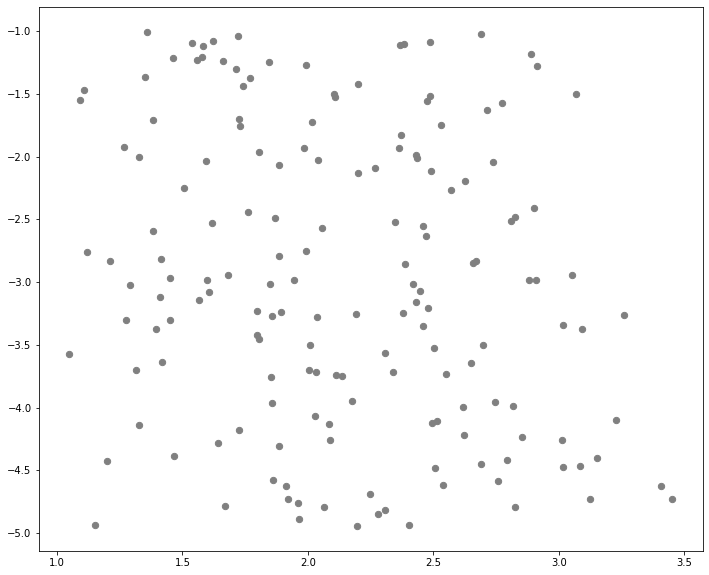

In [19]:
import json
import matplotlib.pyplot as plt
with open('C1C4scanFOPTfromdesktop.txt', 'r') as f2:
    datapoint = json.loads(f2.read()) 
C1ListF=[datapoint[i][6] for i in range(len(datapoint))]
C4ListF=[datapoint[i][8] for i in range(len(datapoint))]
colorListF=[datapoint[i][18] for i in range(len(datapoint))]
plt.figure(figsize=(30,10))
ax = plt.gca()
ax.set_aspect(.5)
i=0
while i<len(C4ListF):
    if colorListF[i]=="gray":
        size=10
        plt.scatter(C1ListF[i],C4ListF[i],c=colorListF[i],s=10)
    else:
        size=40
        plt.scatter(C1ListF[i],C4ListF[i],c=colorListF[i],s=40)
    
    i+=1
    
plt.show